Data Preprocessing & Weekly timelne

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

# Step 2: Data Preprocessing

# 2.1 Load and Inspect the Data
# Load the CSV file
df = pd.read_csv('store_sales.csv')

# Ensure correct data types
df['date'] = pd.to_datetime(df['date'])  # Convert date to datetime
df['store'] = df['store'].astype(int)
df['sales'] = df['sales'].astype(float)
df['promo'] = df['promo'].astype(int)
df['holiday'] = df['holiday'].astype(int)

# 2.2 Handle Missing Values (skipped since you confirmed no missing values)

# 2.3 Convert Dates to Features
# Extract day of week, month, and day of month
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['month'] = df['date'].dt.month  # 1 to 12
df['day_of_month'] = df['date'].dt.day  # 1 to 31

# 2.4 Normalize/Scale the Data
# Initialize scaler for sales
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale sales for each store separately
stores = df['store'].unique()  # Get unique store IDs (1 to 10)
scaled_dfs = []

for store in stores:
    store_df = df[df['store'] == store].copy()
    # Scale sales
    store_df['sales_scaled'] = scaler.fit_transform(store_df[['sales']])
    scaled_dfs.append(store_df)

# Combine scaled data back into one dataframe
df = pd.concat(scaled_dfs, ignore_index=True)

# One-hot encode day of week (categorical)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')

# Scale month and day of month to 0-1 range
df['month_scaled'] = (df['month'] - 1) / 11  # Scale 1-12 to 0-1
df['day_of_month_scaled'] = (df['day_of_month'] - 1) / 30  # Scale 1-31 to 0-1

# 2.5 Handle Multiple Stores
# We'll process each store separately for sequences

# 2.6 Create Time Series Sequences
def create_sequences(data, seq_length=7):
    """
    Create sequences of length `seq_length` for LSTM input.
    Returns X (sequences) and y (target sales).
    """
    X, y = [], []
    feature_cols = ['sales_scaled', 'promo', 'holiday', 'month_scaled', 'day_of_month_scaled'] + \
                   [col for col in data.columns if col.startswith('dow_')]
    
    for i in range(len(data) - seq_length):
        # Extract sequence of length `seq_length`
        seq = data[feature_cols].iloc[i:i + seq_length].values
        # Target is the next day's scaled sales
        target = data['sales_scaled'].iloc[i + seq_length]
        X.append(seq)
        y.append(target)
    
    return np.array(X), np.array(y)

# Sequence length (7 days for weekly)
seq_length = 7

# Dictionary to store sequences for each store
store_sequences = {}

for store in stores:
    store_df = df[df['store'] == store].sort_values('date')  # Ensure chronological order
    X_store, y_store = create_sequences(store_df, seq_length)
    store_sequences[store] = {'X': X_store, 'y': y_store}

# 2.7 Split the Data
# Split into training (70%), validation (15%), and test (15%) sets for each store
train_data = {}
val_data = {}
test_data = {}

for store in stores:
    X = store_sequences[store]['X']
    y = store_sequences[store]['y']
    
    # First, split into train+val (85%) and test (15%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, shuffle=False  # No shuffling for time series
    )
    
    # Then, split train+val into train (70/85 ≈ 82.35%) and val (15/85 ≈ 17.65%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, shuffle=False
    )
    
    train_data[store] = {'X': X_train, 'y': y_train}
    val_data[store] = {'X': X_val, 'y': y_val}
    test_data[store] = {'X': X_test, 'y': y_test}

# Save the scaler for later inverse transformation
scalers = {store: scaler for store in stores}

# Print shapes to verify
for store in stores:
    print(f"Store {store}:")
    print(f"  Training data: X shape = {train_data[store]['X'].shape}, y shape = {train_data[store]['y'].shape}")
    print(f"  Validation data: X shape = {val_data[store]['X'].shape}, y shape = {val_data[store]['y'].shape}")
    print(f"  Test data: X shape = {test_data[store]['X'].shape}, y shape = {test_data[store]['y'].shape}")

Store 1:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape = (109, 7, 12), y shape = (109,)
  Test data: X shape = (109, 7, 12), y shape = (109,)
Store 2:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape = (109, 7, 12), y shape = (109,)
  Test data: X shape = (109, 7, 12), y shape = (109,)
Store 3:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape = (109, 7, 12), y shape = (109,)
  Test data: X shape = (109, 7, 12), y shape = (109,)
Store 4:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape = (109, 7, 12), y shape = (109,)
  Test data: X shape = (109, 7, 12), y shape = (109,)
Store 5:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape = (109, 7, 12), y shape = (109,)
  Test data: X shape = (109, 7, 12), y shape = (109,)
Store 6:
  Training data: X shape = (505, 7, 12), y shape = (505,)
  Validation data: X shape =

Visualize the sales per store, on Daily basis

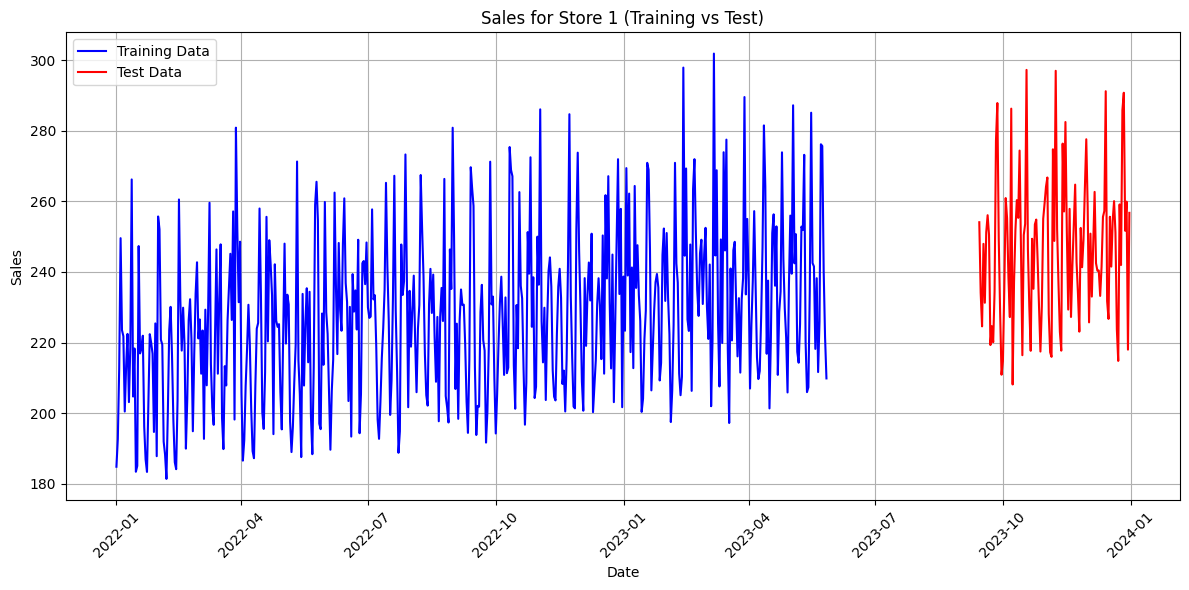

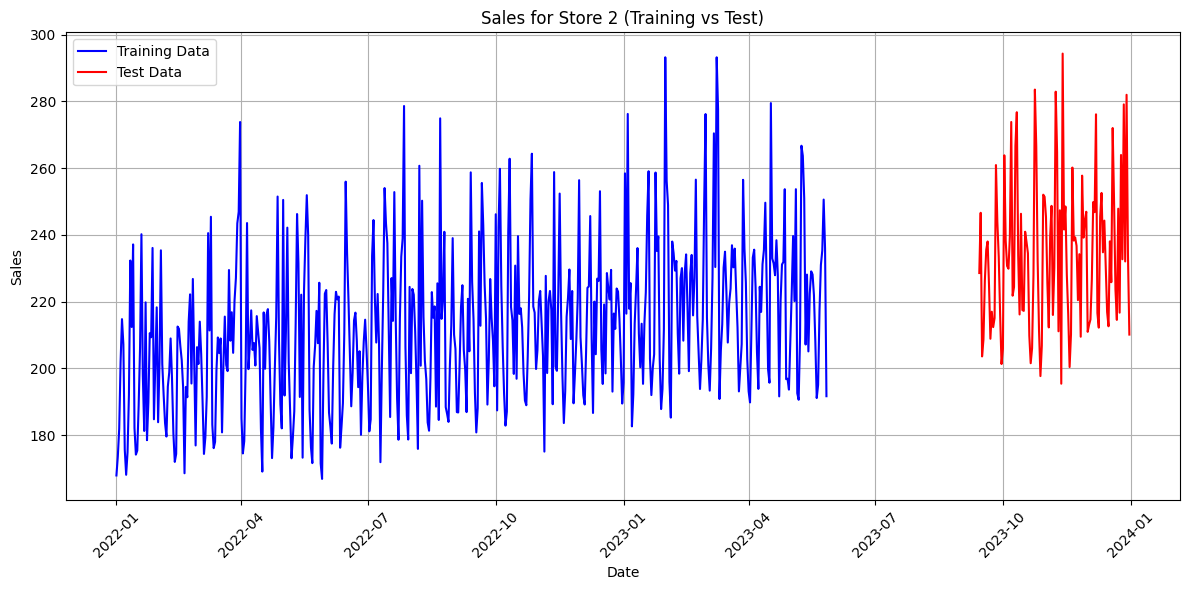

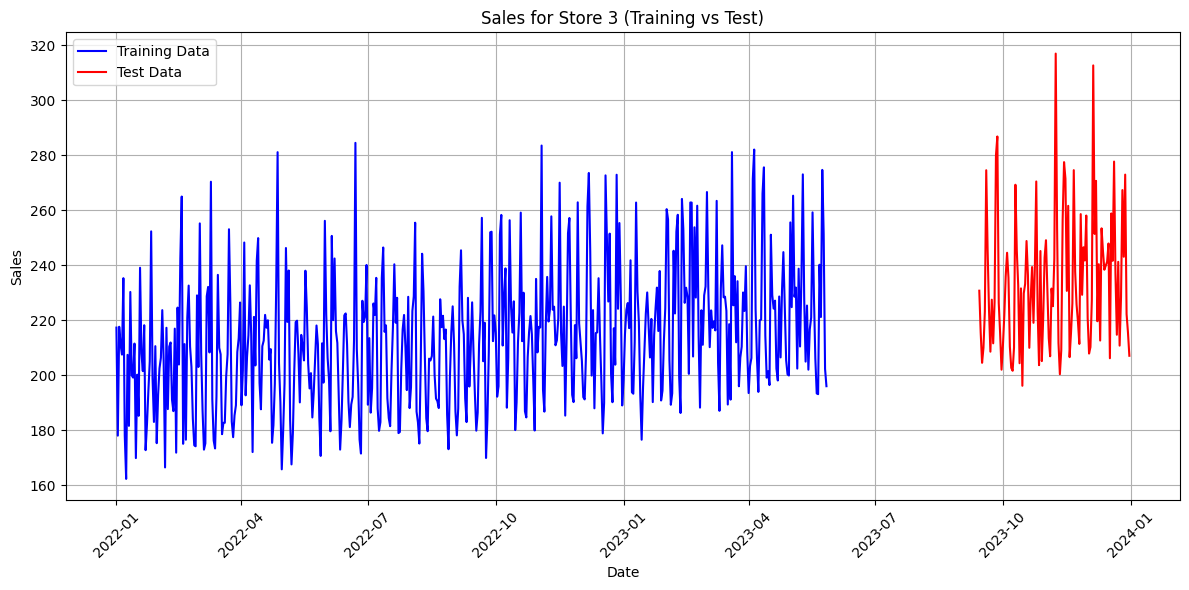

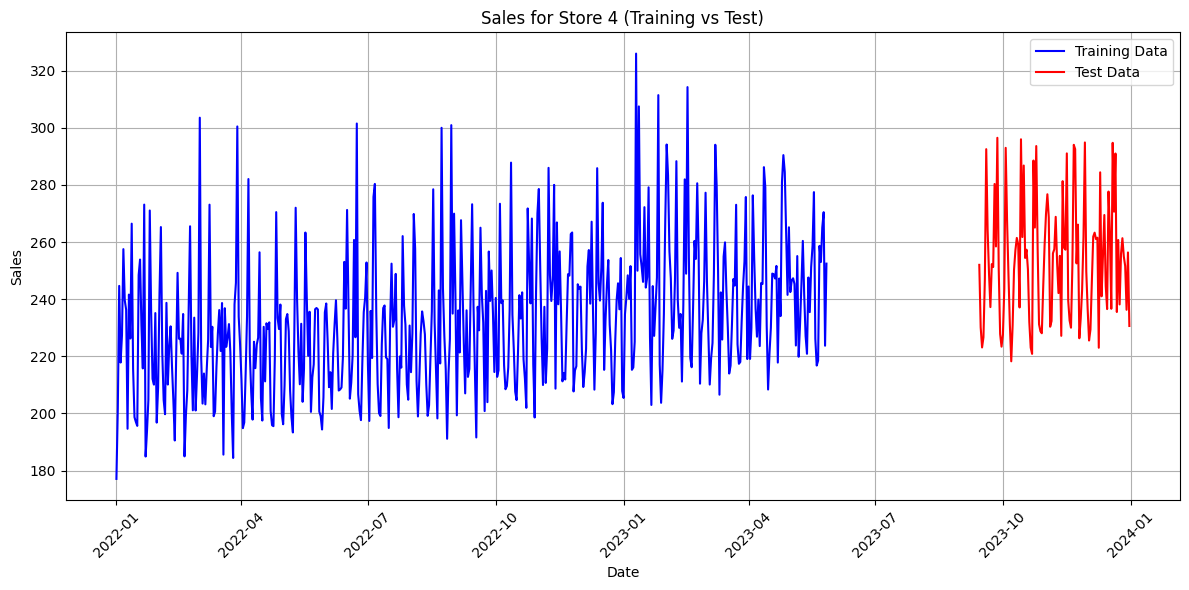

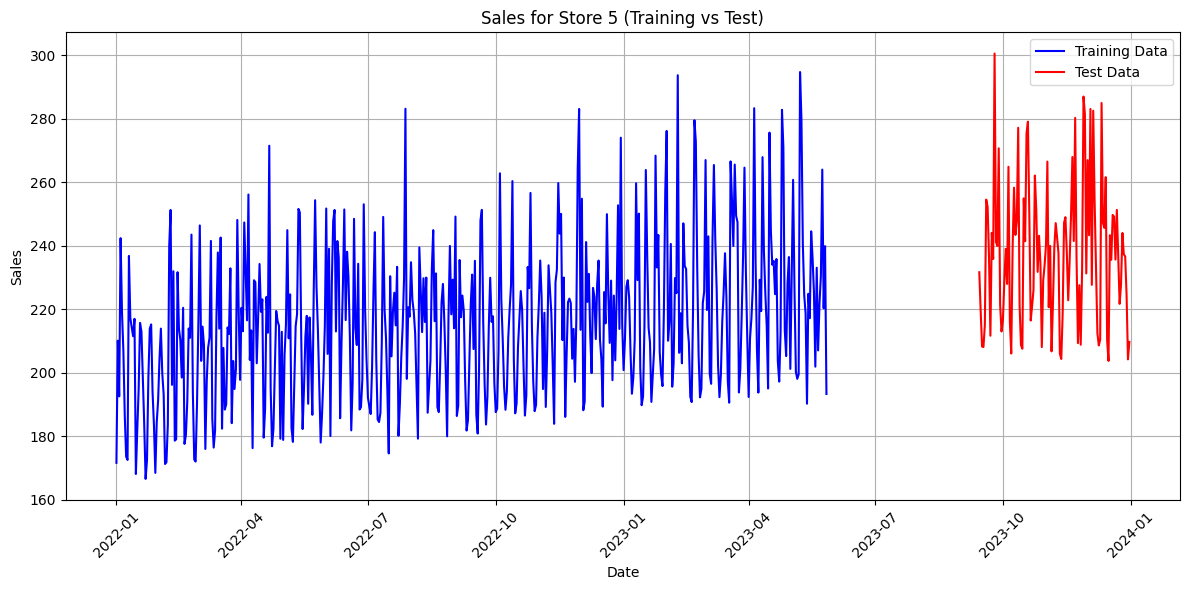

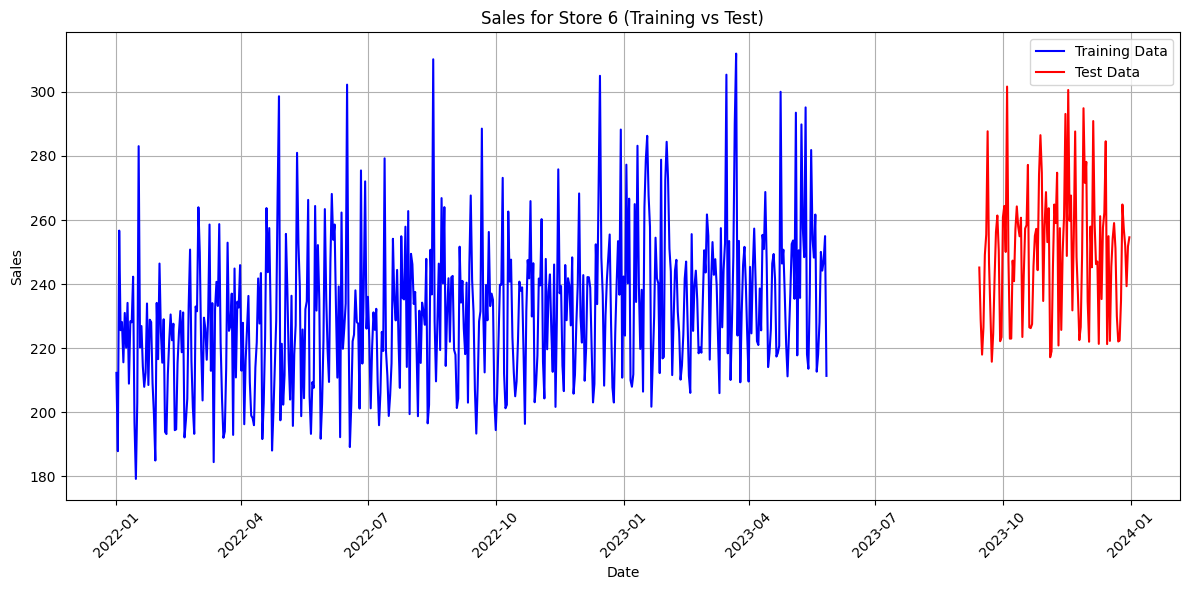

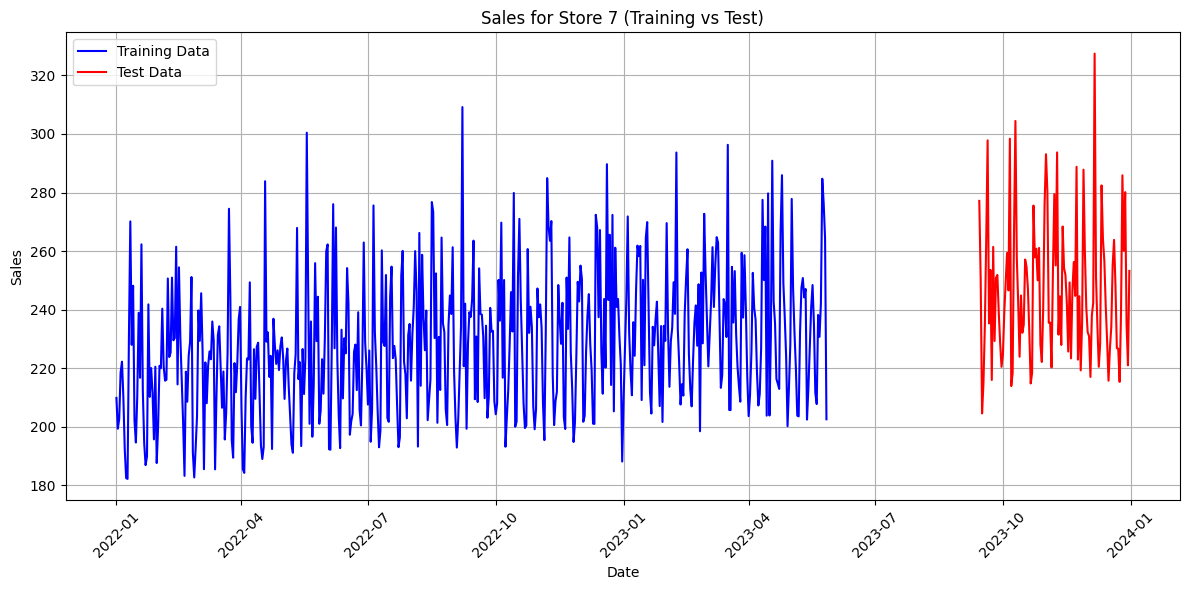

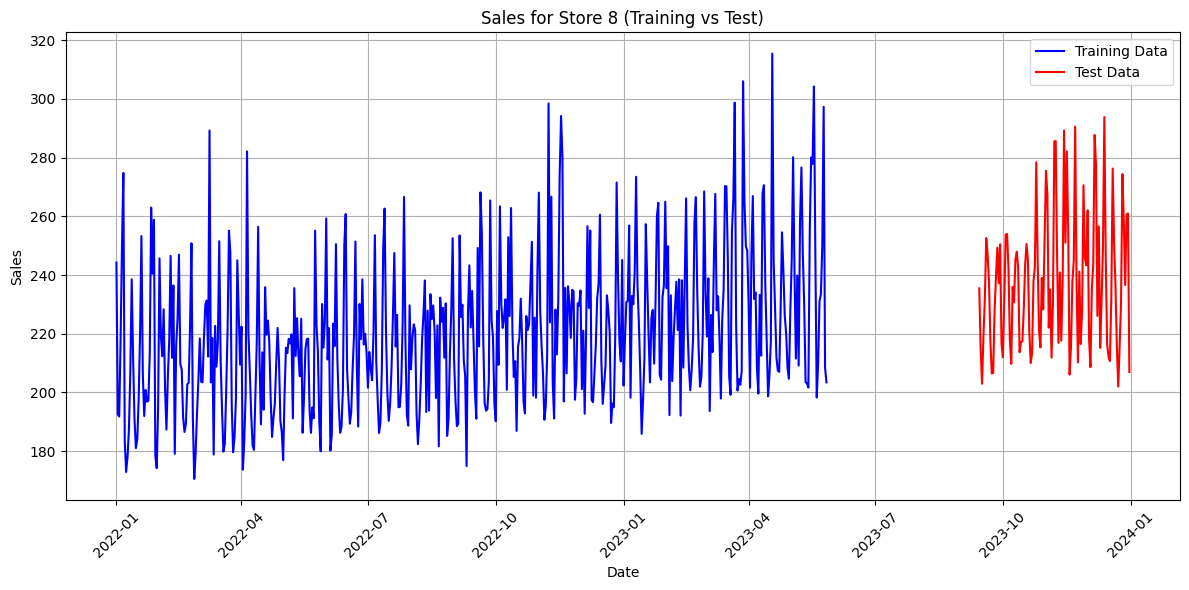

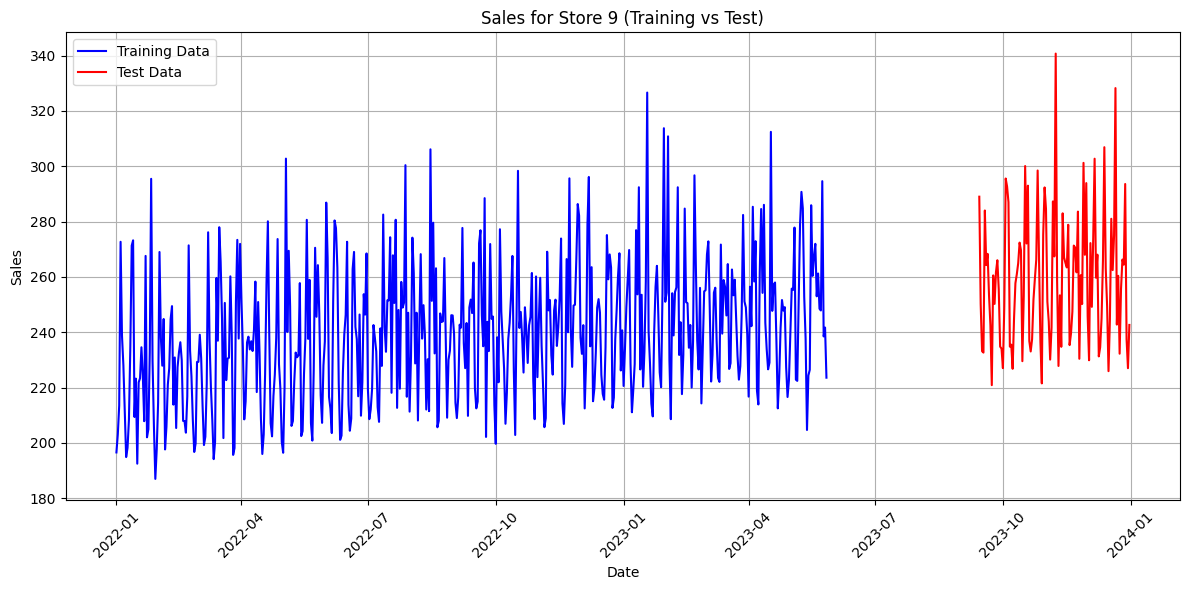

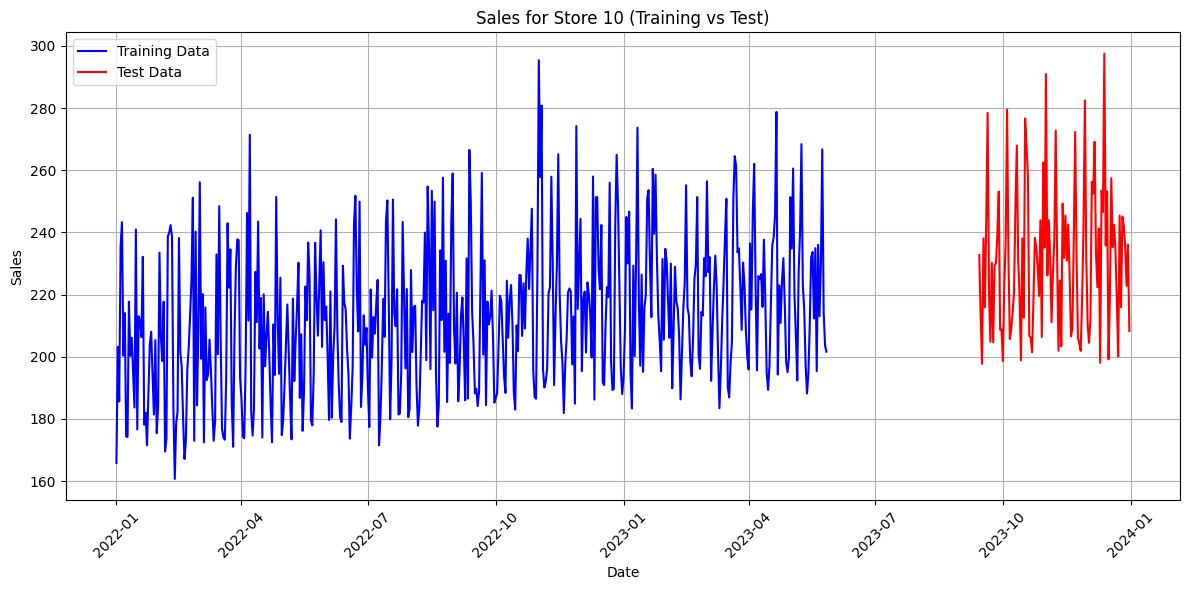

In [2]:
import matplotlib.pyplot as plt

# Plot sales for each store with training and test parts in different colors
for store in stores:
    # Filter data for the current store
    store_df = df[df['store'] == store].sort_values('date')
    
    # Get indices for training and test sets based on the split from preprocessing
    train_size = len(train_data[store]['y'])
    test_size = len(test_data[store]['y'])
    val_size = len(val_data[store]['y'])
    
    # Calculate the split points
    total_len = len(store_df)
    train_end = train_size + seq_length  # Account for sequence length
    test_start = total_len - test_size
    
    # Extract training and test data
    train_sales = store_df['sales'].iloc[:train_end]
    train_dates = store_df['date'].iloc[:train_end]
    test_sales = store_df['sales'].iloc[test_start:]
    test_dates = store_df['date'].iloc[test_start:]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_dates, train_sales, label='Training Data', color='blue')
    plt.plot(test_dates, test_sales, label='Test Data', color='red')
    
    # Add title and labels
    plt.title(f'Sales for Store {store} (Training vs Test)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Visualizing on weely basis

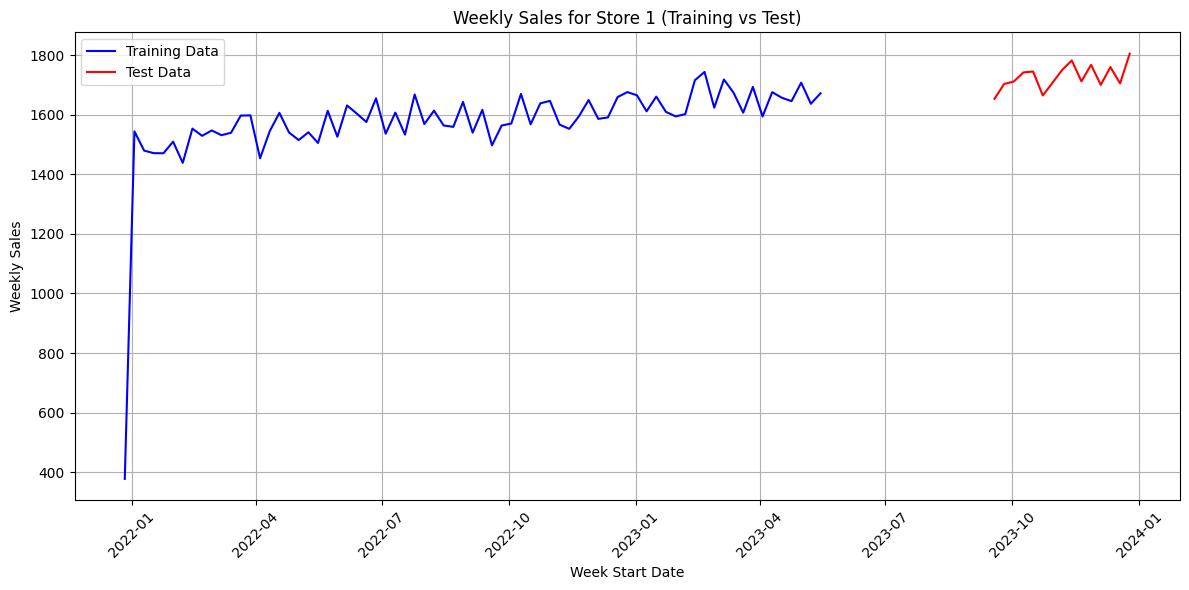

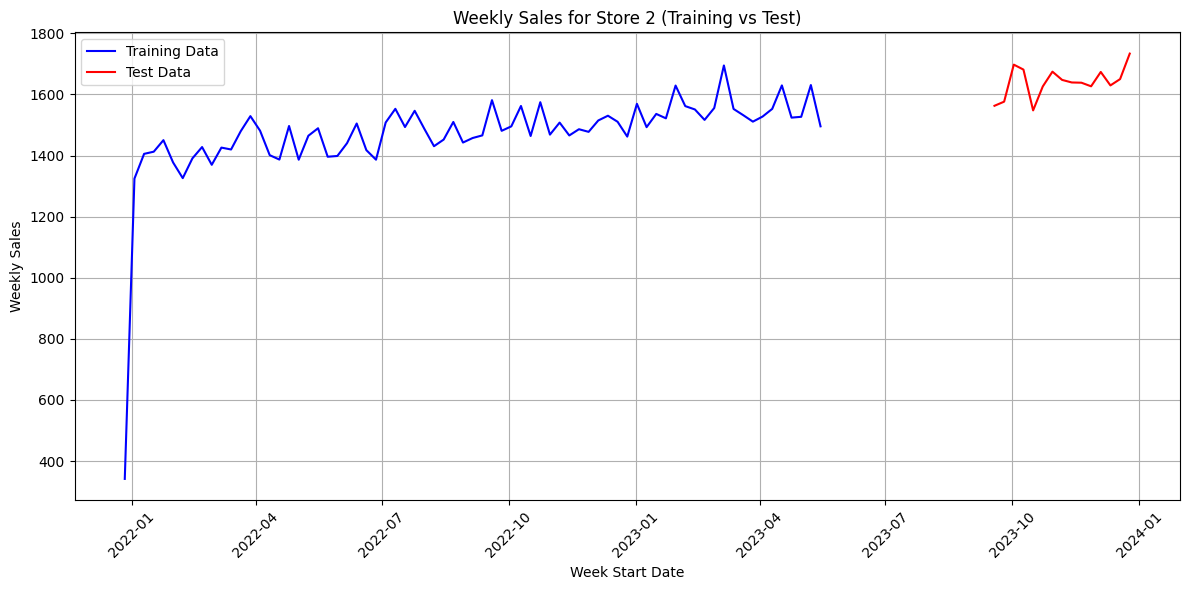

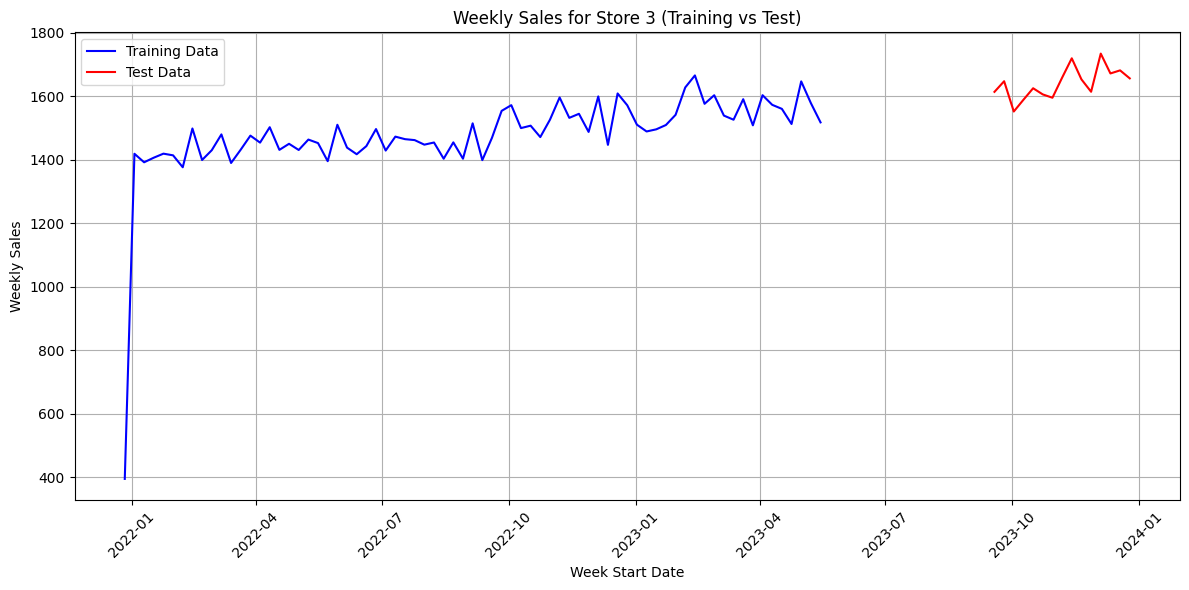

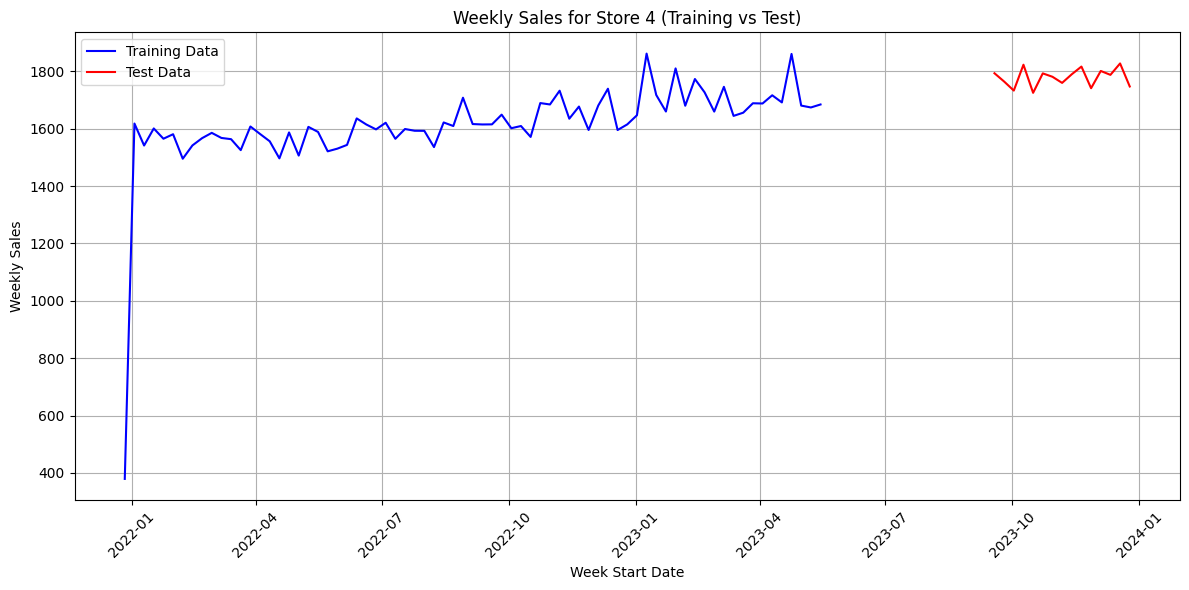

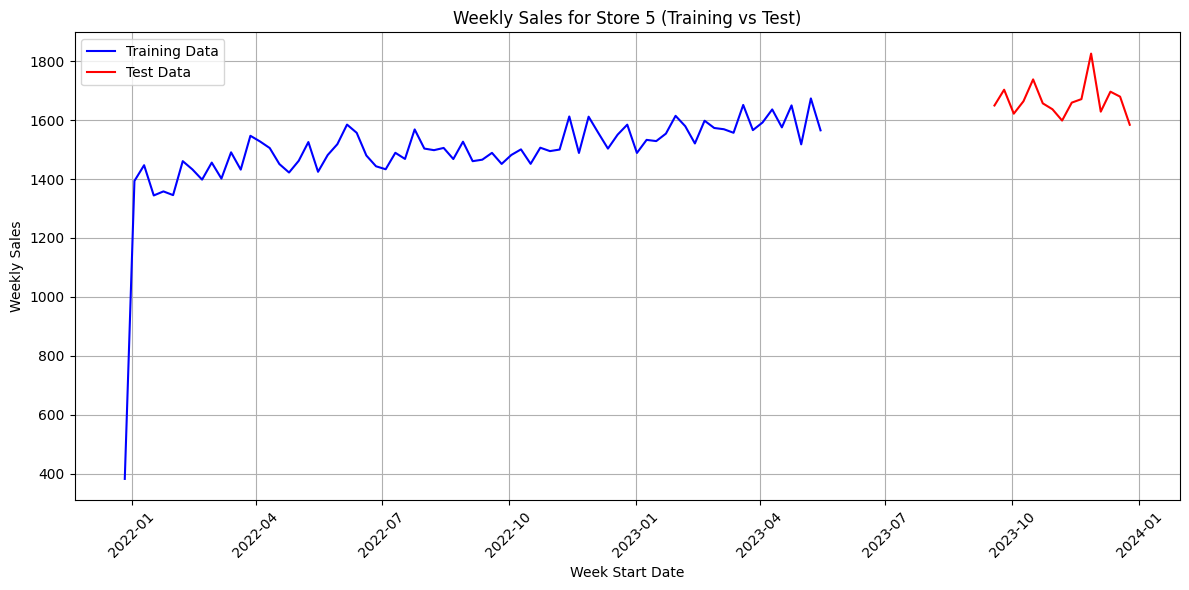

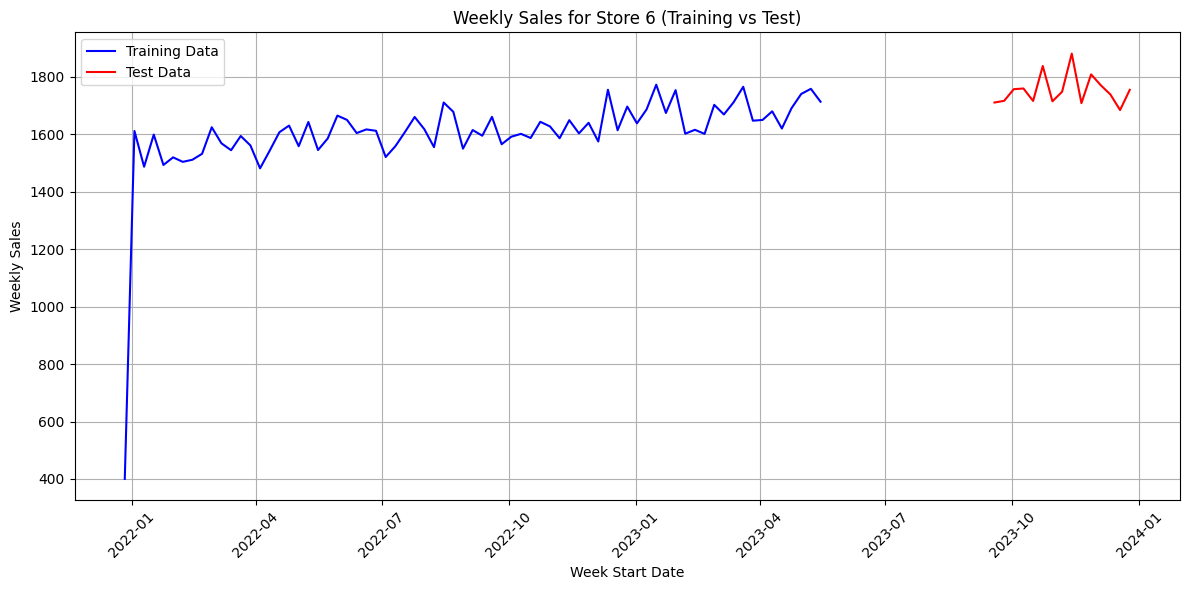

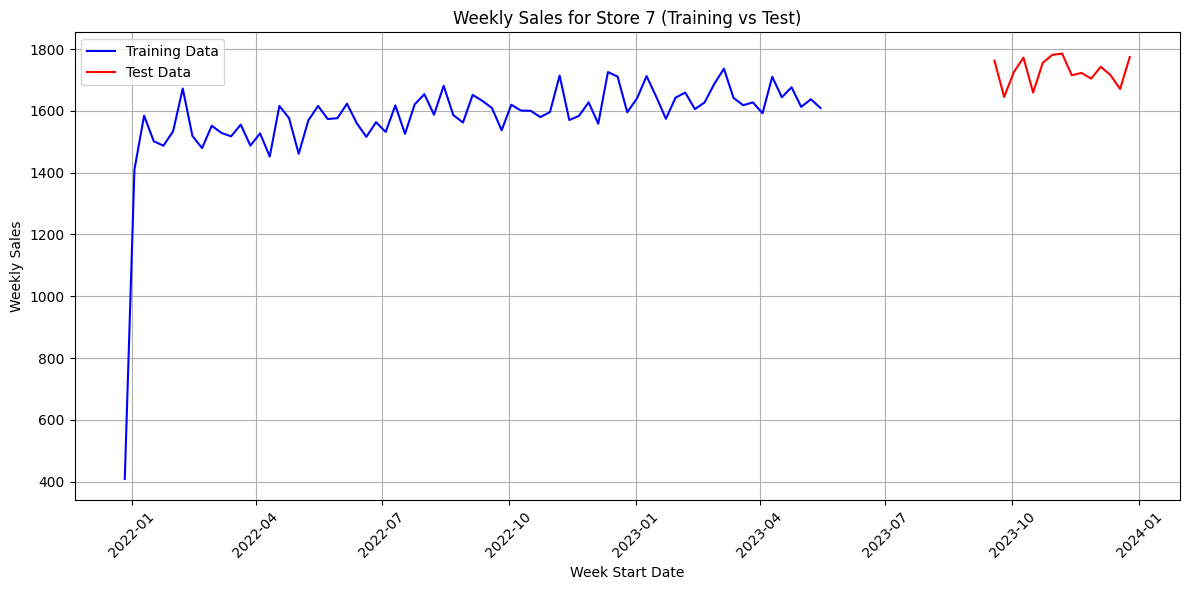

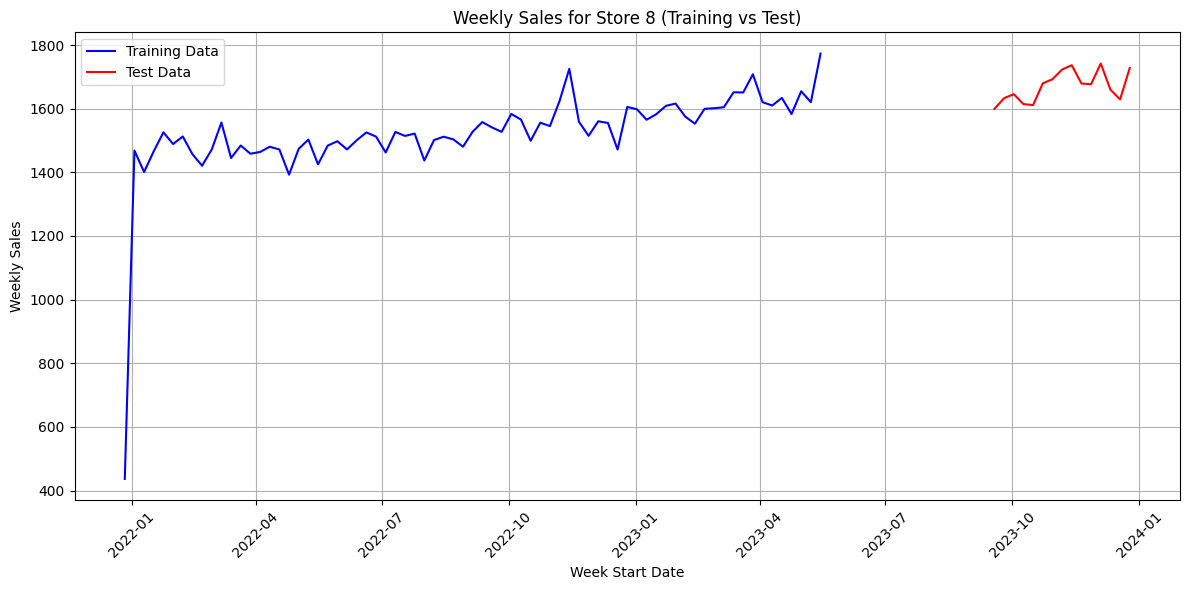

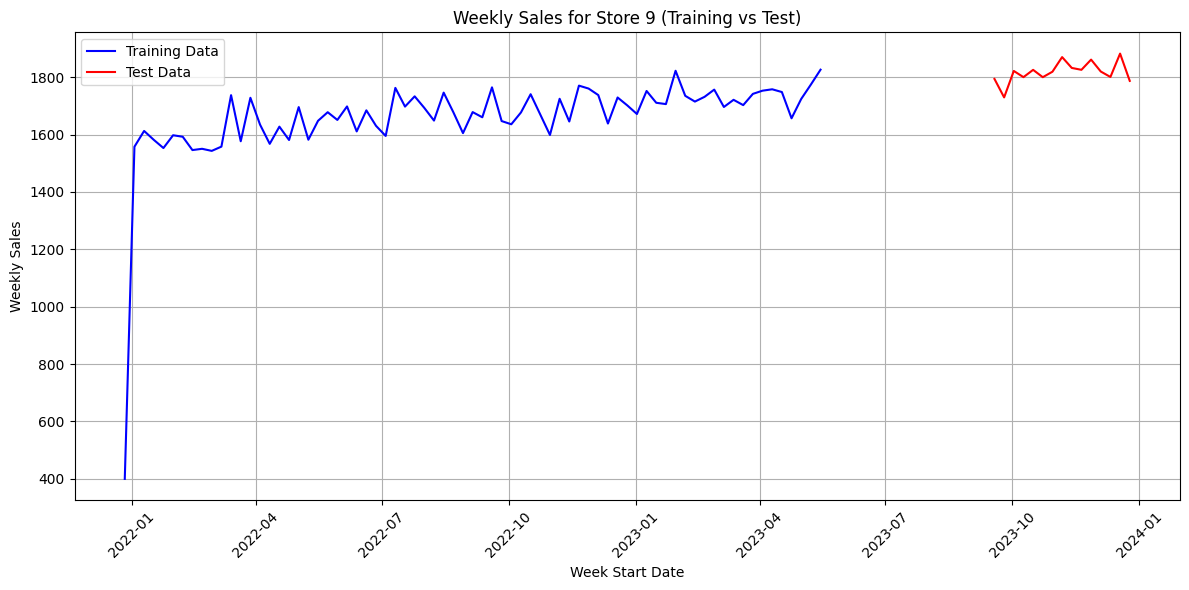

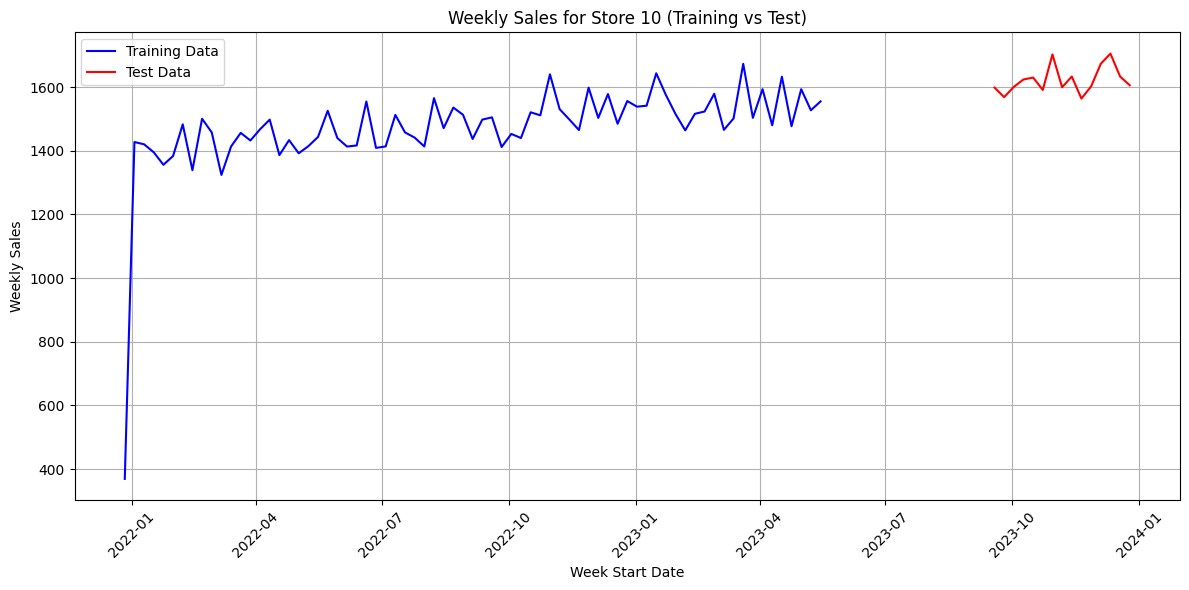

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot weekly sales for each store with training and test parts in different colors
for store in stores:
    # Filter data for the current store
    store_df = df[df['store'] == store].sort_values('date')
    
    # Aggregate daily sales to weekly sales (sum over each week)
    store_df['week_start'] = store_df['date'].dt.to_period('W').dt.start_time
    weekly_df = store_df.groupby('week_start')['sales'].sum().reset_index()
    
    # Get indices for training and test sets based on the split from preprocessing
    train_size = len(train_data[store]['y'])
    test_size = len(test_data[store]['y'])
    
    # Calculate approximate weekly split points (assuming ~7 days per week)
    total_days = len(store_df)
    total_weeks = len(weekly_df)
    weeks_per_day = total_weeks / total_days
    train_weeks = int(train_size * weeks_per_day) + 1  # Account for sequence length
    test_weeks = int(test_size * weeks_per_day)
    
    # Extract training and test data
    train_sales = weekly_df['sales'].iloc[:train_weeks]
    train_dates = weekly_df['week_start'].iloc[:train_weeks]
    test_sales = weekly_df['sales'].iloc[-test_weeks:]
    test_dates = weekly_df['week_start'].iloc[-test_weeks:]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_dates, train_sales, label='Training Data', color='blue')
    plt.plot(test_dates, test_sales, label='Test Data', color='red')
    
    # Add title and labels
    plt.title(f'Weekly Sales for Store {store} (Training vs Test)')
    plt.xlabel('Week Start Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Step 3:- Build LSTM model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 3: Build the LSTM Model

# Dictionary to store models for each store
models = {}

# Define LSTM model for each store
for store in stores:
    # Get input shape from training data
    input_shape = (train_data[store]['X'].shape[1], train_data[store]['X'].shape[2])  # (seq_length=7, num_features)

    # Create model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),  # 20% dropout to prevent overfitting
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)  # Output layer for predicting next day's scaled sales
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Store model in dictionary
    models[store] = model

    # Print model summary for verification
    print(f"Model for Store {store}:")
    model.summary()

Model for Store 1:


C:\Users\Bhushan N\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 3:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 4:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 5:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 6:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 7:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 8:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 9:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Model for Store 10:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 7, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Again Step 1,2,3 & 4

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Data Preprocessing (Updated to Fix Dtype Issue)

# 2.1 Load and Inspect the Data
df = pd.read_csv('store_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df['store'] = df['store'].astype(int)
df['sales'] = df['sales'].astype(float)
df['promo'] = df['promo'].astype(int)
df['holiday'] = df['holiday'].astype(int)

# 2.3 Convert Dates to Features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

# 2.4 Normalize/Scale the Data
scaler = MinMaxScaler(feature_range=(0, 1))
stores = df['store'].unique()
scaled_dfs = []

for store in stores:
    store_df = df[df['store'] == store].copy()
    store_df['sales_scaled'] = scaler.fit_transform(store_df[['sales']])
    scaled_dfs.append(store_df)

df = pd.concat(scaled_dfs, ignore_index=True)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')
df['month_scaled'] = (df['month'] - 1) / 11
df['day_of_month_scaled'] = (df['day_of_month'] - 1) / 30

# 2.6 Create Time Series Sequences (Updated)
def create_sequences(data, seq_length=7):
    """
    Create sequences of length `seq_length` for LSTM input.
    Returns X (sequences) and y (target sales) as float32.
    """
    X, y = [], []
    feature_cols = ['sales_scaled', 'promo', 'holiday', 'month_scaled', 'day_of_month_scaled'] + \
                   [col for col in data.columns if col.startswith('dow_')]
    
    for i in range(len(data) - seq_length):
        seq = data[feature_cols].iloc[i:i + seq_length].values.astype(np.float32)  # Convert to float32
        target = data['sales_scaled'].iloc[i + seq_length].astype(np.float32)  # Convert to float32
        X.append(seq)
        y.append(target)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)  # Ensure arrays are float32

seq_length = 7
store_sequences = {}

for store in stores:
    store_df = df[df['store'] == store].sort_values('date')
    X_store, y_store = create_sequences(store_df, seq_length)
    store_sequences[store] = {'X': X_store, 'y': y_store}

# 2.7 Split the Data
train_data = {}
val_data = {}
test_data = {}
scalers = {store: scaler for store in stores}

for store in stores:
    X = store_sequences[store]['X']
    y = store_sequences[store]['y']
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.15, shuffle=False
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, shuffle=False
    )
    train_data[store] = {'X': X_train, 'y': y_train}
    val_data[store] = {'X': X_val, 'y': y_val}
    test_data[store] = {'X': X_test, 'y': y_test}

# Step 3: Build the LSTM Model (Unchanged, included for completeness)
models = {}
for store in stores:
    input_shape = (train_data[store]['X'].shape[1], train_data[store]['X'].shape[2])
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    models[store] = model

# Step 4: Train the Model (Unchanged)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for store in stores:
    print(f"Training model for Store {store}...")
    X_train = train_data[store]['X']
    y_train = train_data[store]['y']
    X_val = val_data[store]['X']
    y_val = val_data[store]['y']
    
    history = models[store].fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print(f"Store {store} - Final validation loss: {history.history['val_loss'][-1]:.4f}")

C:\Users\Bhushan N\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for Store 1...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0493 - val_loss: 0.0307
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0257 - val_loss: 0.0335
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0211 - val_loss: 0.0266
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0185 - val_loss: 0.0250
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170 - val_loss: 0.0232
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - val_loss: 0.0296
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0162 - val_loss: 0.0273
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0172 - val_loss: 0.0283
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0164 - val_loss: 0.0274
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0159 - val_loss: 0.0203
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - val_loss: 0.0179
Epoch 12/100
16/16 ━━━

In [29]:
import joblib

# During training, save scalers as a dictionary
scalers = {}  # Initialize as dictionary
for store in range(1, 11):
    # Fit and store scaler for each store (assuming this was done in preprocessing)
    scaler = MinMaxScaler(feature_range=(0, 1))  # Reinitialize or use the one from preprocessing
    # scaler.fit(df[df['store'] == store][['sales']])  # Fit to store's sales if not already done
    scalers[store] = scaler  # Store each scaler with store key

# Save trained model for each store
for store in range(1, 11):
    joblib.dump(models[store], f'model_store_{store}.joblib')

# Save scaler dictionary
joblib.dump(scalers, 'scalers.pkl')

# Save test data
joblib.dump(test_data, 'test_data.pkl')

# Save the original dataframe
joblib.dump(df, 'df.pkl')

['df.pkl']

Step 5:- Evaluation of the model/Testing the model

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 5: Evaluate the Model

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Evaluate each store's model on the test set
for store in stores:
    print(f"Evaluating model for Store {store}...")
    
    # Get test data
    X_test = test_data[store]['X']
    y_test = test_data[store]['y']
    
    # Make predictions
    y_pred_scaled = models[store].predict(X_test, verbose=0)
    
    # Inverse transform predictions and actual values to original sales scale
    y_pred = scalers[store].inverse_transform(y_pred_scaled)
    y_test_unscaled = scalers[store].inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)
    
    # Print results
    print(f"Store {store} - Test Set Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")

Evaluating model for Store 1...
Store 1 - Test Set Metrics:
  MAE: 11.3144
  RMSE: 15.7694
  MAPE: 4.8843%
Evaluating model for Store 2...
Store 2 - Test Set Metrics:
  MAE: 19.3470
  RMSE: 25.0039
  MAPE: 8.0415%
Evaluating model for Store 3...
Store 3 - Test Set Metrics:
  MAE: 11.6769
  RMSE: 16.4615
  MAPE: 4.9420%
Evaluating model for Store 4...
Store 4 - Test Set Metrics:
  MAE: 11.6513
  RMSE: 16.0998
  MAPE: 4.8341%
Evaluating model for Store 5...
Store 5 - Test Set Metrics:
  MAE: 16.6643
  RMSE: 20.6279
  MAPE: 7.2188%
Evaluating model for Store 6...
Store 6 - Test Set Metrics:
  MAE: 17.3497
  RMSE: 21.4830
  MAPE: 7.5425%
Evaluating model for Store 7...
Store 7 - Test Set Metrics:
  MAE: 17.4922
  RMSE: 22.5451
  MAPE: 7.6610%
Evaluating model for Store 8...
Store 8 - Test Set Metrics:
  MAE: 17.5479
  RMSE: 21.5535
  MAPE: 8.0031%
Evaluating model for Store 9...
Store 9 - Test Set Metrics:
  MAE: 18.7180
  RMSE: 23.8644
  MAPE: 7.9767%
Evaluating model for Store 10...
Stor

Visualization

Evaluating model for Store 1...
Store 1 - Test Set Metrics:
  MAE: 11.3144
  RMSE: 15.7694
  MAPE: 4.8843%


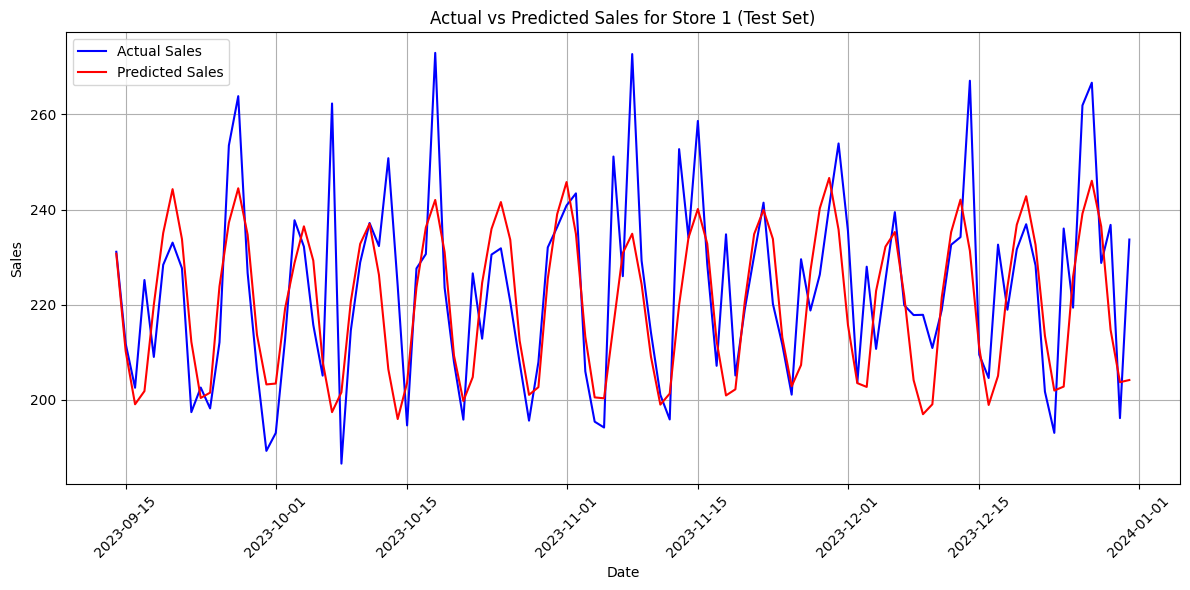

Evaluating model for Store 2...
Store 2 - Test Set Metrics:
  MAE: 19.3470
  RMSE: 25.0039
  MAPE: 8.0415%


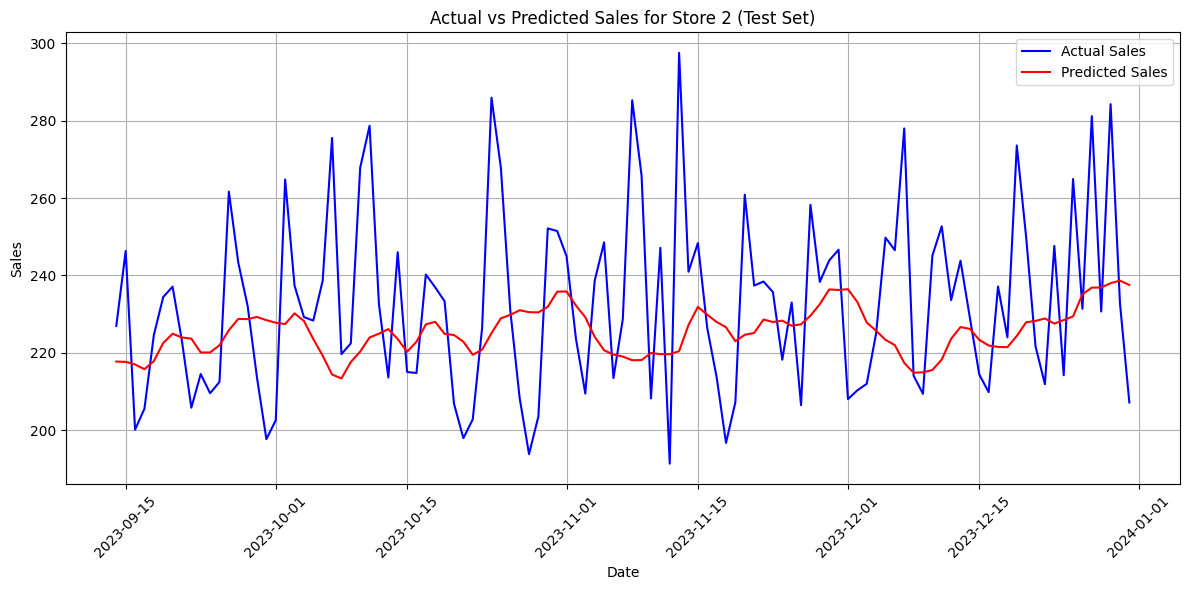

Evaluating model for Store 3...
Store 3 - Test Set Metrics:
  MAE: 11.6769
  RMSE: 16.4615
  MAPE: 4.9420%


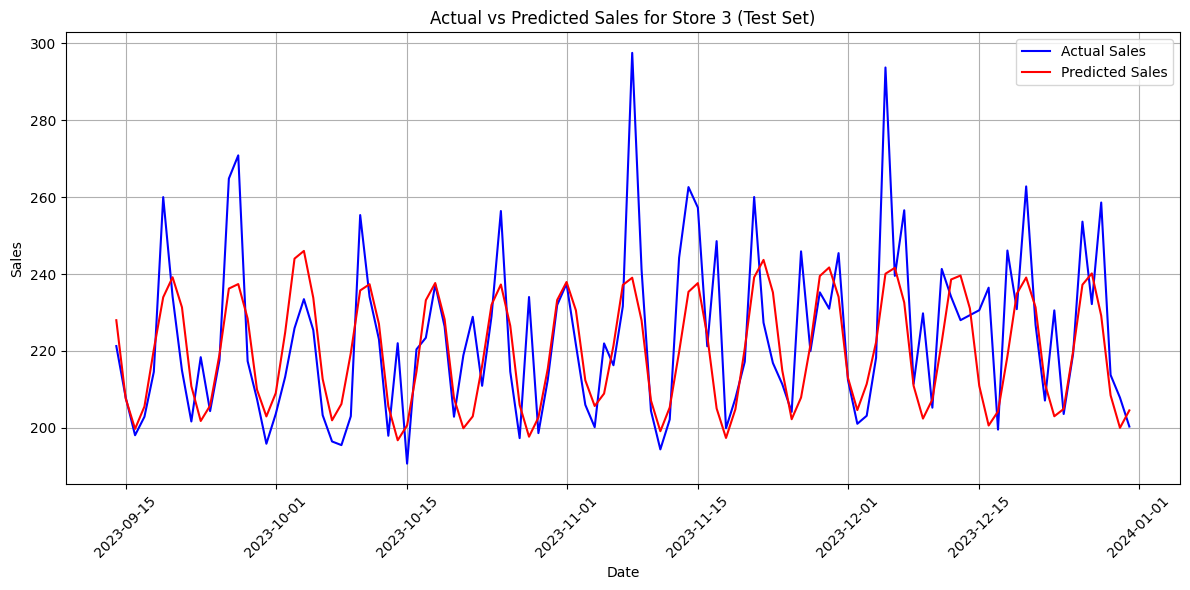

Evaluating model for Store 4...
Store 4 - Test Set Metrics:
  MAE: 11.6513
  RMSE: 16.0998
  MAPE: 4.8341%


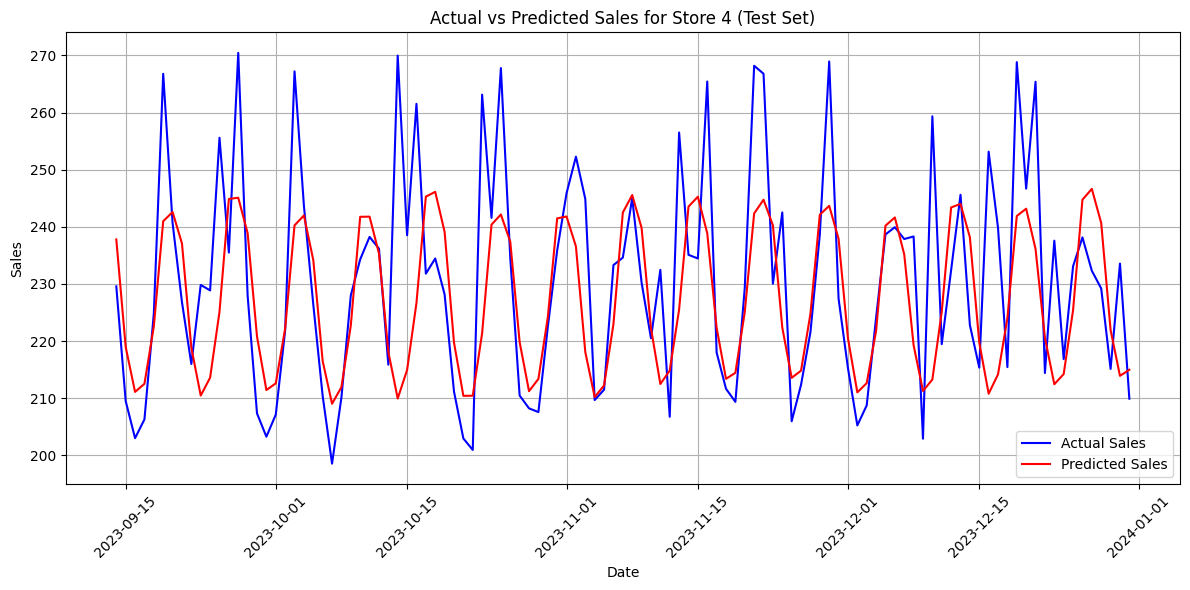

Evaluating model for Store 5...
Store 5 - Test Set Metrics:
  MAE: 16.6643
  RMSE: 20.6279
  MAPE: 7.2188%


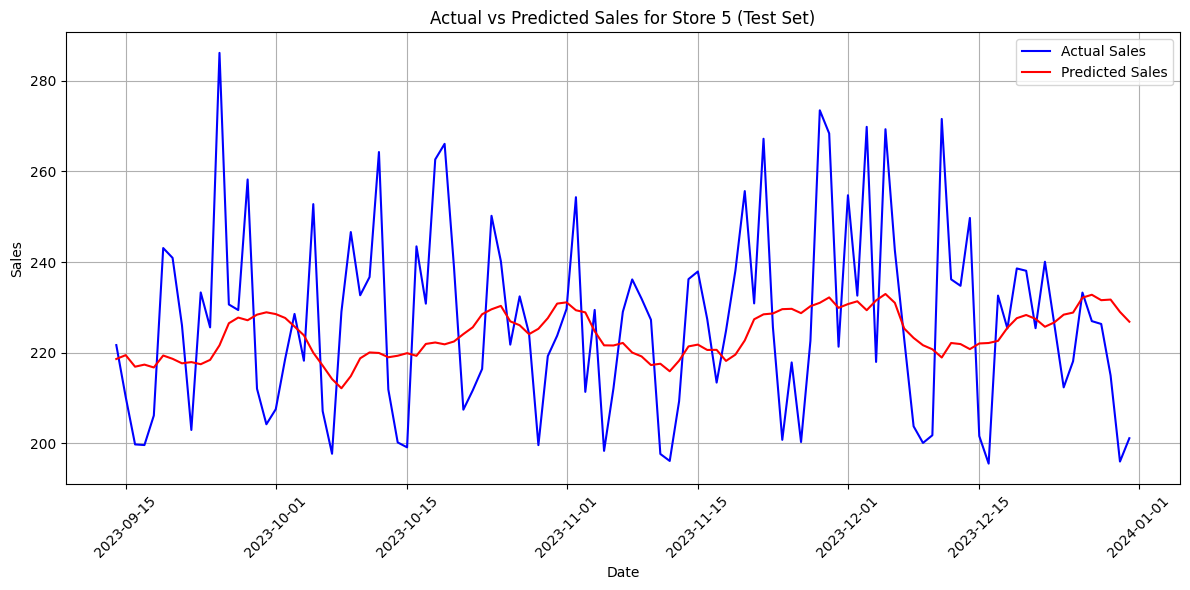

Evaluating model for Store 6...
Store 6 - Test Set Metrics:
  MAE: 17.3497
  RMSE: 21.4830
  MAPE: 7.5425%


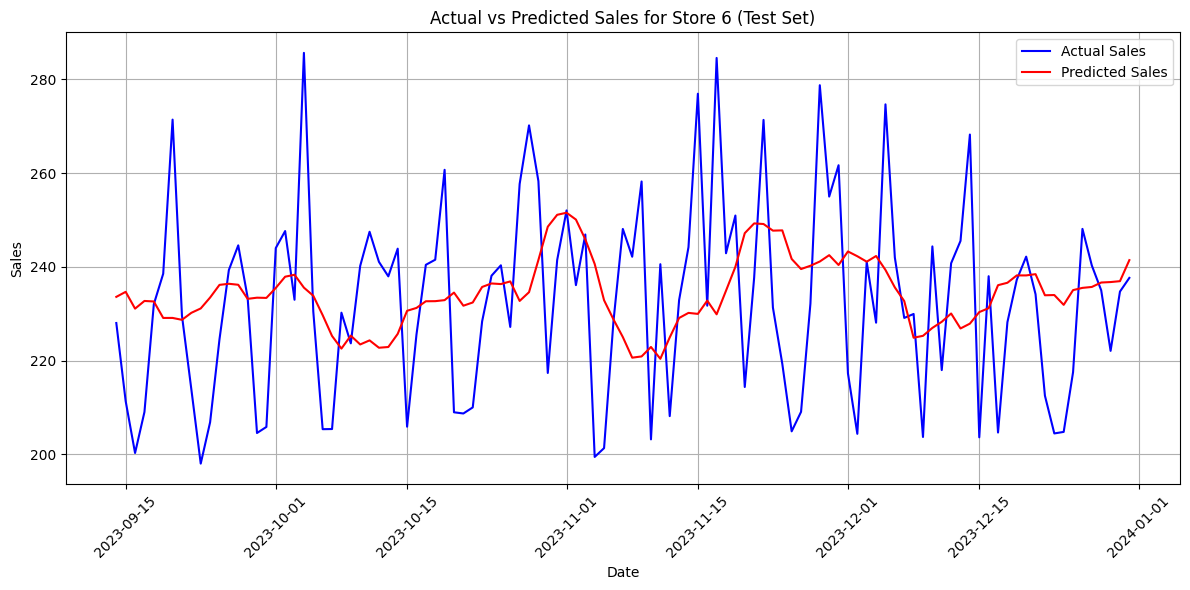

Evaluating model for Store 7...
Store 7 - Test Set Metrics:
  MAE: 17.4922
  RMSE: 22.5451
  MAPE: 7.6610%


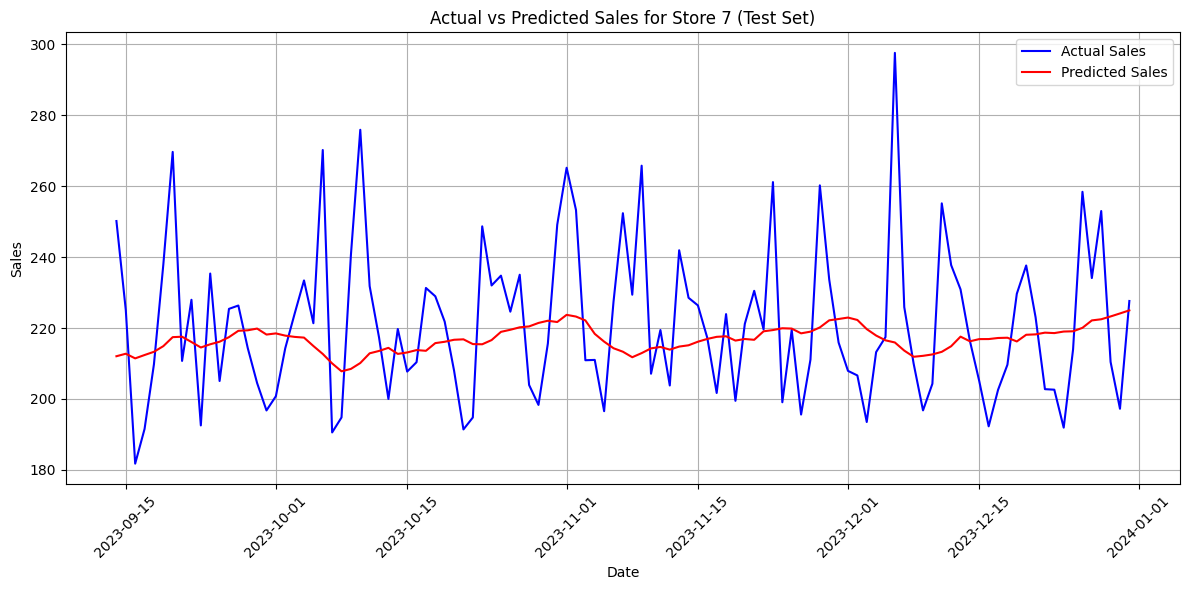

Evaluating model for Store 8...
Store 8 - Test Set Metrics:
  MAE: 17.5479
  RMSE: 21.5535
  MAPE: 8.0031%


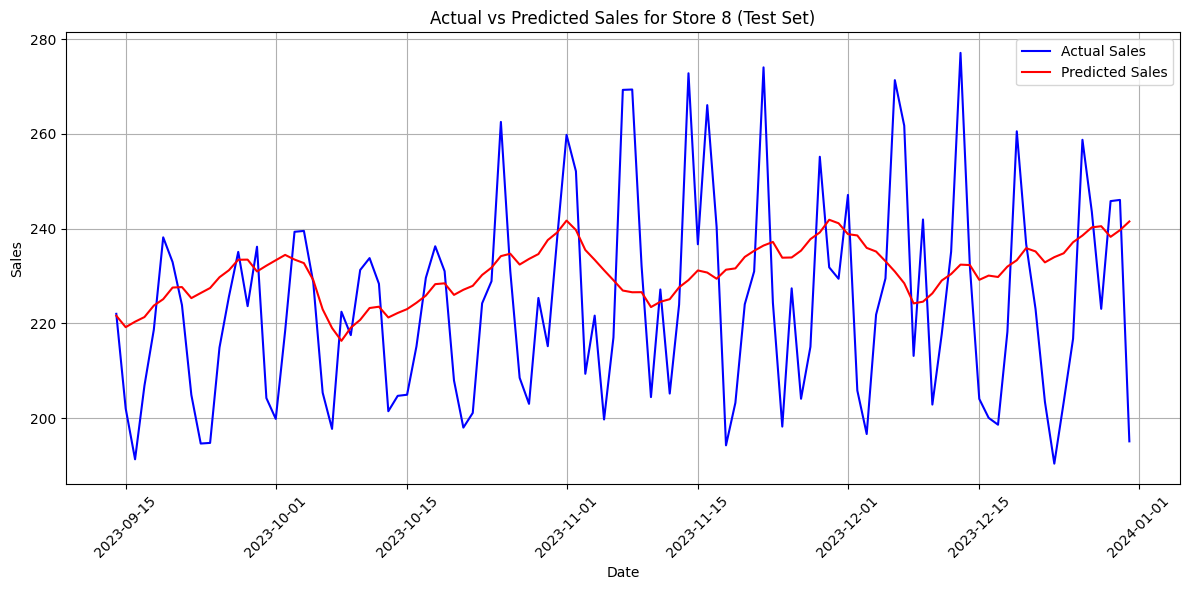

Evaluating model for Store 9...
Store 9 - Test Set Metrics:
  MAE: 18.7180
  RMSE: 23.8644
  MAPE: 7.9767%


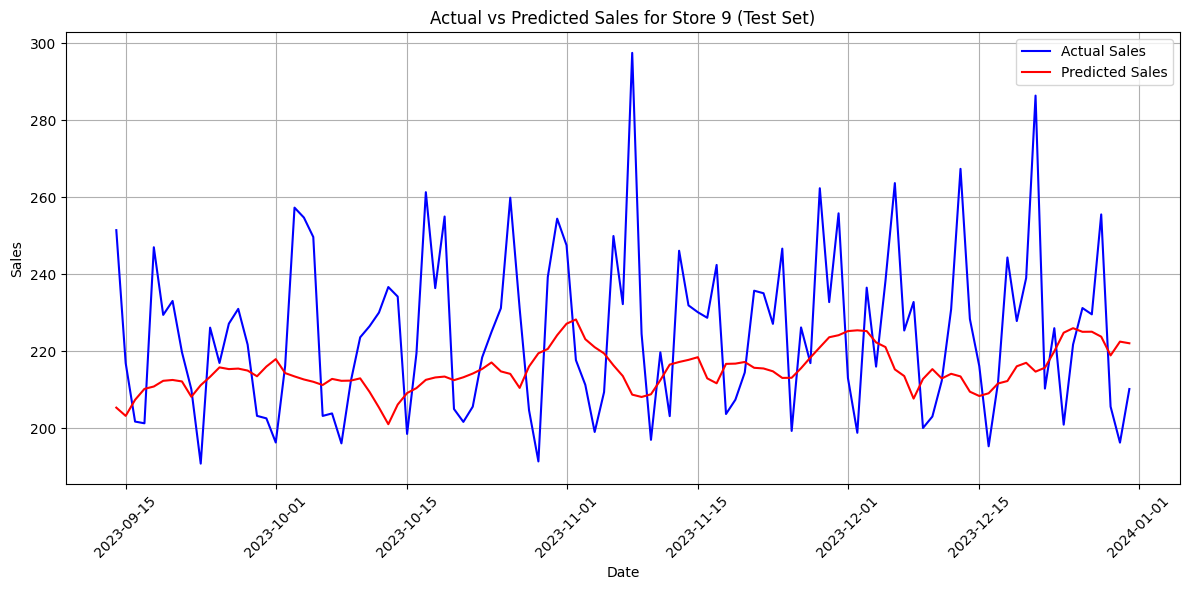

Evaluating model for Store 10...
Store 10 - Test Set Metrics:
  MAE: 19.3031
  RMSE: 23.5386
  MAPE: 8.5228%


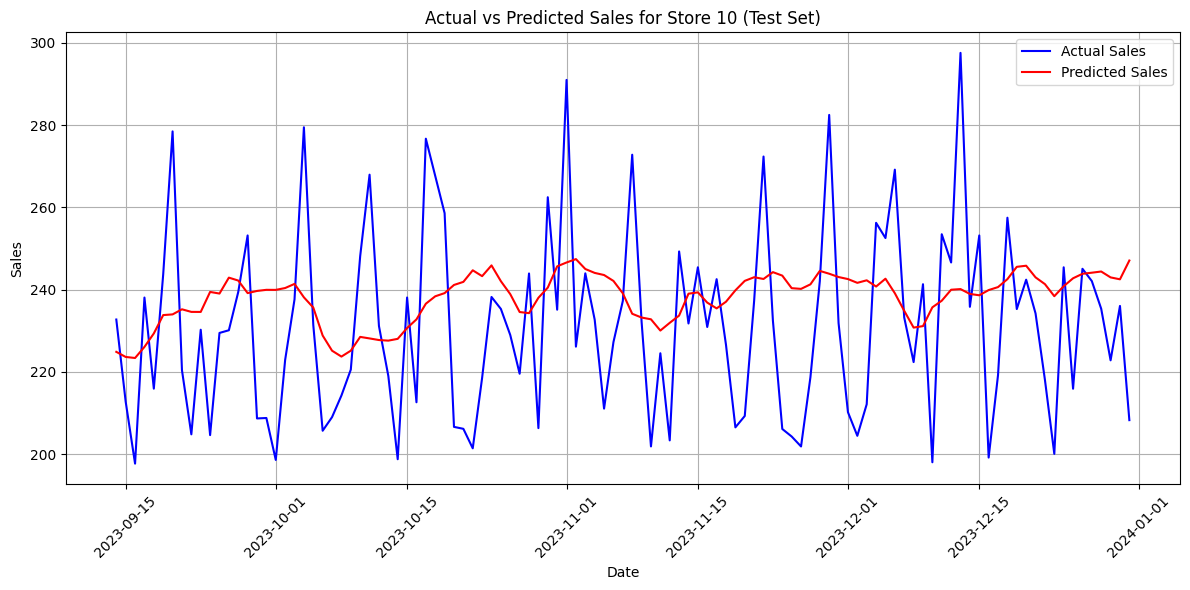

In [8]:
import matplotlib.pyplot as plt

# Add plotting to Step 5: Evaluate the Model
for store in stores:
    print(f"Evaluating model for Store {store}...")
    
    # Get test data
    X_test = test_data[store]['X']
    y_test = test_data[store]['y']
    
    # Make predictions
    y_pred_scaled = models[store].predict(X_test, verbose=0)
    
    # Inverse transform predictions and actual values to original sales scale
    y_pred = scalers[store].inverse_transform(y_pred_scaled)
    y_test_unscaled = scalers[store].inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_unscaled, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred)
    
    # Print results
    print(f"Store {store} - Test Set Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}%")
    
    # Plot actual vs predicted sales
    # Get dates for the test set (shifted by seq_length to align with predictions)
    store_df = df[df['store'] == store].sort_values('date')
    test_dates = store_df['date'].iloc[-len(y_test):].values
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_unscaled, label='Actual Sales', color='blue')
    plt.plot(test_dates, y_pred, label='Predicted Sales', color='red')
    
    # Add title and labels
    plt.title(f'Actual vs Predicted Sales for Store {store} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Hyper parameter tuning

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input  # Corrected import for Input
from tensorflow.keras.optimizers import Adam
import joblib
from sklearn.model_selection import train_test_split

# Load preprocessed data (from Step 2)
df = pd.read_csv('store_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
scaler = MinMaxScaler(feature_range=(0, 1))
stores = df['store'].unique()
scaled_dfs = []

for store in stores:
    store_df = df[df['store'] == store].copy()
    store_df['sales_scaled'] = scaler.fit_transform(store_df[['sales']])
    scaled_dfs.append(store_df)

df = pd.concat(scaled_dfs, ignore_index=True)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')
df['month_scaled'] = (df['month'] - 1) / 11
df['day_of_month_scaled'] = (df['day_of_month'] - 1) / 30

# Function to create sequences with additional features
def create_sequences_with_features(data, seq_length=7):
    X, y = [], []
    feature_cols = ['sales_scaled', 'promo', 'holiday', 'month_scaled', 'day_of_month_scaled'] + \
                   [col for col in data.columns if col.startswith('dow_')]
    
    # Add lagged sales (e.g., 7 days ago)
    data['lagged_sales'] = data['sales_scaled'].shift(7)
    data['lagged_sales'] = data['lagged_sales'].fillna(0)  # Avoid inplace
    feature_cols.append('lagged_sales')
    
    # Add 7-day moving average
    data['moving_avg_7'] = data['sales_scaled'].rolling(window=7).mean()
    data['moving_avg_7'] = data['moving_avg_7'].fillna(data['sales_scaled'].mean())  # Avoid inplace
    feature_cols.append('moving_avg_7')
    
    for i in range(len(data) - seq_length):
        seq = data[feature_cols].iloc[i:i + seq_length].values
        target = data['sales_scaled'].iloc[i + seq_length]
        X.append(seq)
        y.append(target)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Fine-tune parameters
seq_lengths = [7, 14, 30]  # Different sequence lengths to test
lstm_units = [50, 100]  # Different numbers of LSTM units
learning_rates = [0.001, 0.01]  # Different learning rates
best_models = {}

for store in stores:
    store_df = df[df['store'] == store].sort_values('date')
    best_mae = float('inf')
    best_model = None
    
    for seq_length in seq_lengths:
        for units in lstm_units:
            for lr in learning_rates:
                # Create sequences
                X, y = create_sequences_with_features(store_df, seq_length)
                
                # Split data
                X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
                X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, shuffle=False)
                
                # Build and compile model with Input layer
                model = Sequential()
                model.add(Input(shape=(seq_length, X.shape[2])))
                model.add(LSTM(units=units, return_sequences=True))
                model.add(Dropout(0.2))
                model.add(LSTM(units=units))
                model.add(Dropout(0.2))
                model.add(Dense(1))
                model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
                
                # Train model
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                  epochs=50, batch_size=32, verbose=0)
                
                # Evaluate on validation set
                val_pred = model.predict(X_val)
                mae = np.mean(np.abs(val_pred - y_val))
                
                if mae < best_mae:
                    best_mae = mae
                    best_model = model
                    best_params = {'seq_length': seq_length, 'units': units, 'lr': lr}
    
    # Save the best model
    joblib.dump(best_model, f'best_model_store_{store}.joblib')
    best_models[store] = best_params
    print(f"Store {store}: Best MAE = {best_mae:.4f}, Params = {best_params}")

# Save the scaler
joblib.dump(scaler, 'scalers.pkl')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Store 1: Best MAE = 0.1507, Params = {'seq_length': 7, 'units': 100, 'lr': 0.001}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Store 

['scalers.pkl']

Forecasting using fine tuned model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Evaluating model for Store 1...
Store 1 - Test Set Metrics: MAE: 11.1826 RMSE: 16.0179 MAPE: 4.8094%


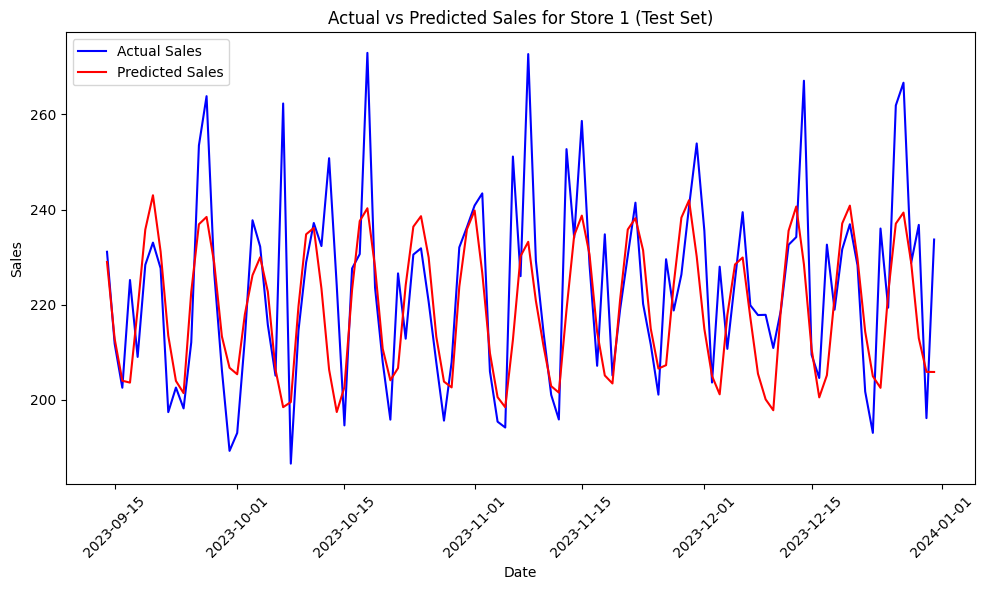

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Evaluating model for Store 2...
Store 2 - Test Set Metrics: MAE: 15.0857 RMSE: 20.6493 MAPE: 6.1810%


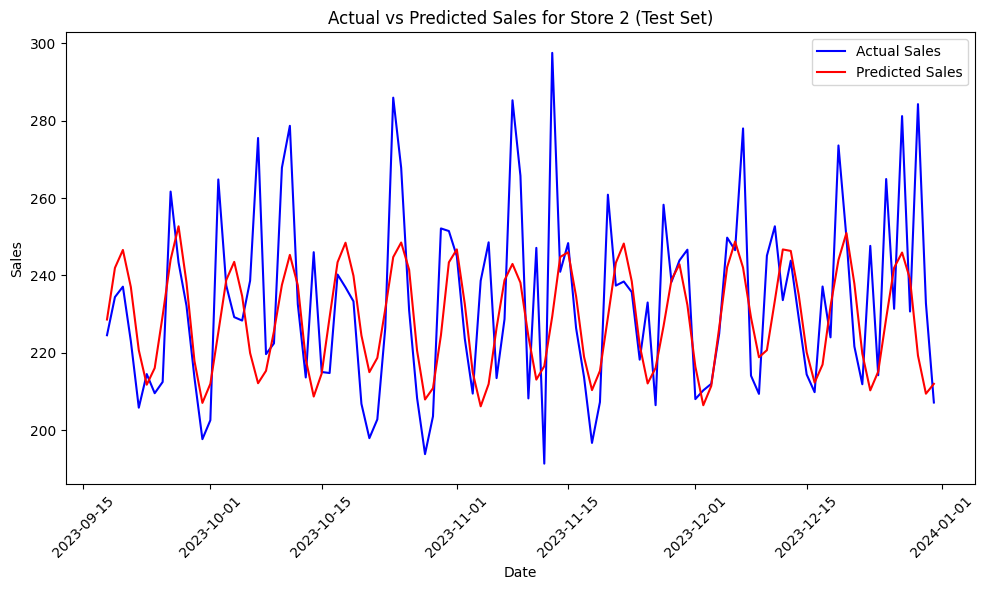

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Evaluating model for Store 3...
Store 3 - Test Set Metrics: MAE: 11.3175 RMSE: 17.1118 MAPE: 4.7270%


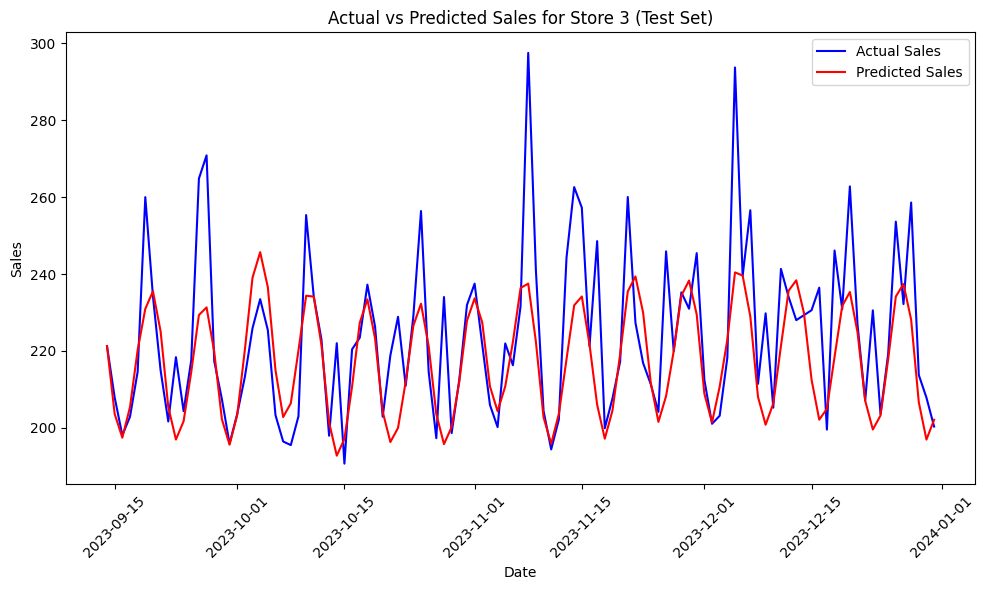

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Evaluating model for Store 4...
Store 4 - Test Set Metrics: MAE: 16.1017 RMSE: 21.0961 MAPE: 6.7602%


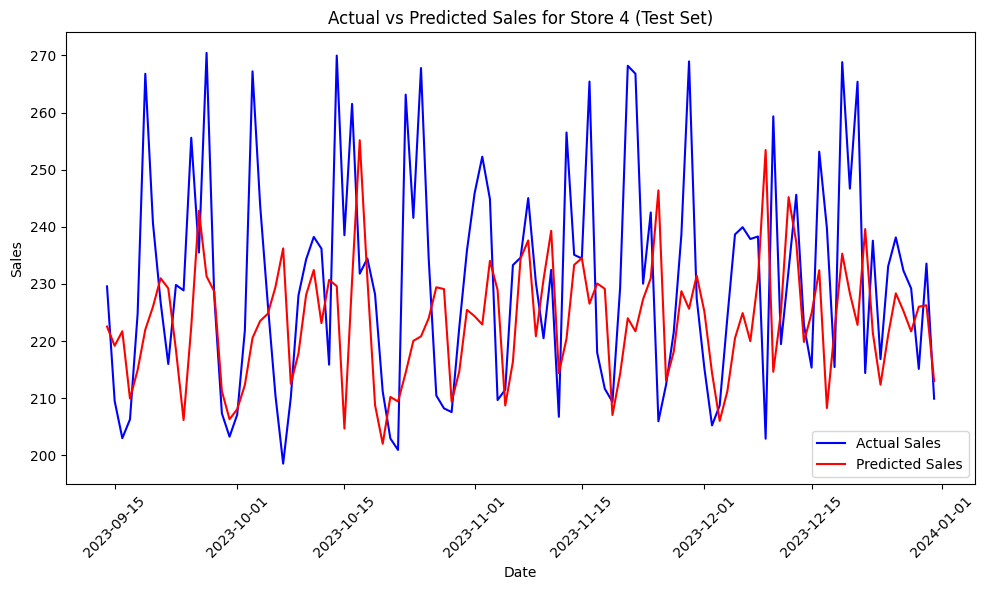

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Evaluating model for Store 5...
Store 5 - Test Set Metrics: MAE: 15.4423 RMSE: 21.1042 MAPE: 6.4699%


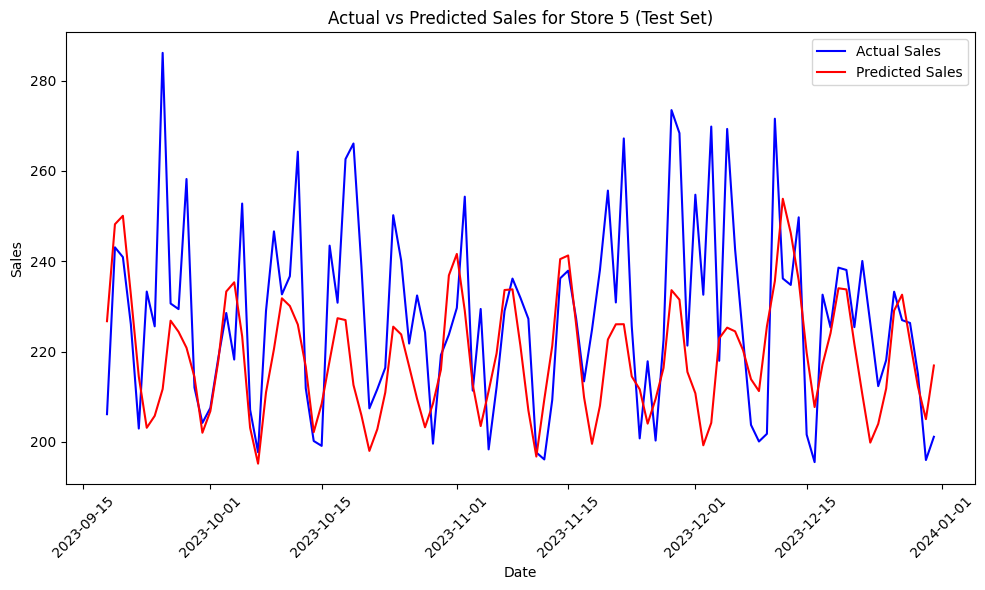

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Evaluating model for Store 6...
Store 6 - Test Set Metrics: MAE: 12.5866 RMSE: 17.9556 MAPE: 5.2121%


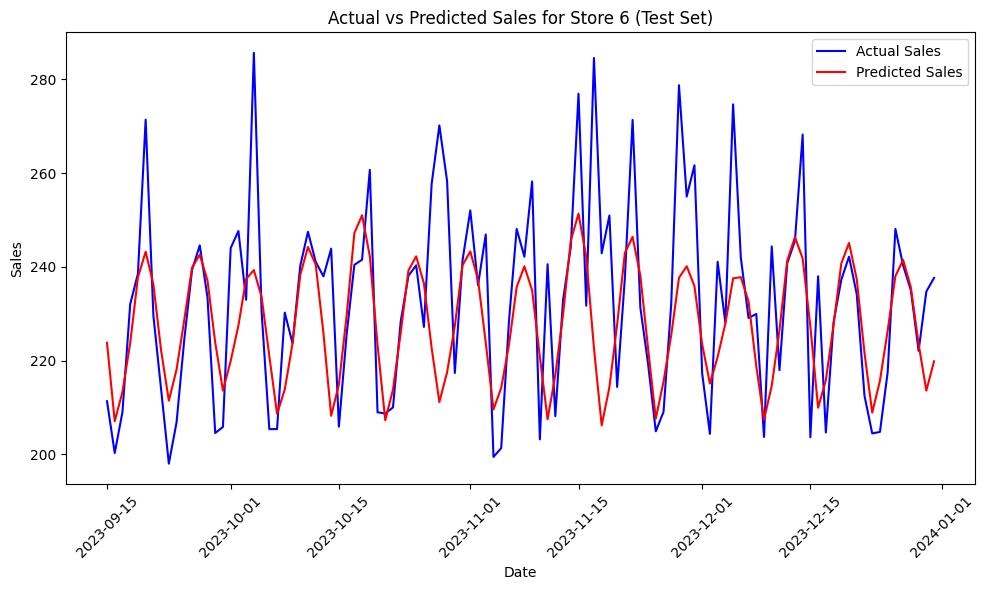

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Evaluating model for Store 7...
Store 7 - Test Set Metrics: MAE: 12.3214 RMSE: 17.2716 MAPE: 5.2826%


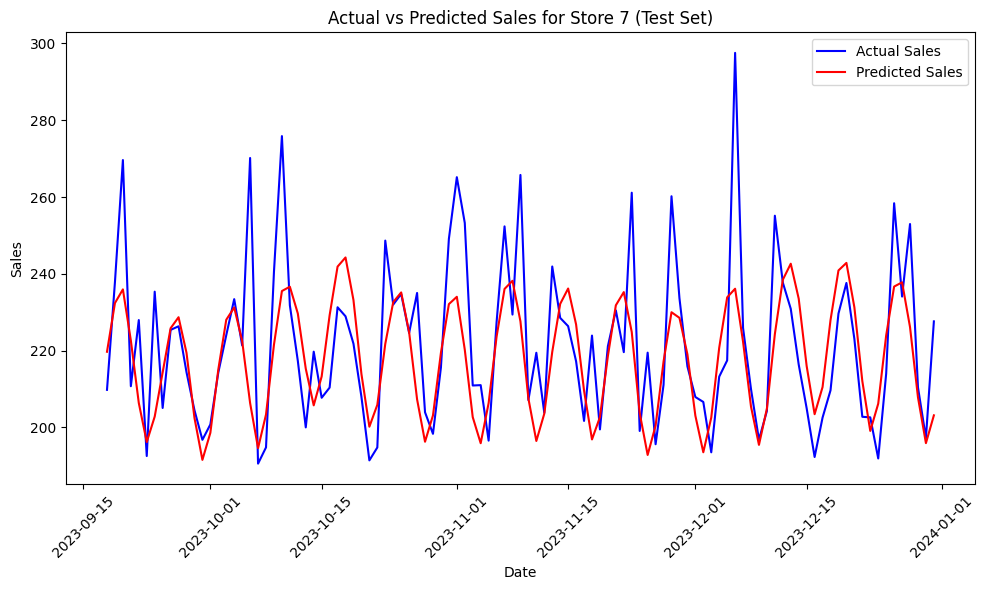

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Evaluating model for Store 8...
Store 8 - Test Set Metrics: MAE: 11.0582 RMSE: 15.8648 MAPE: 4.6650%


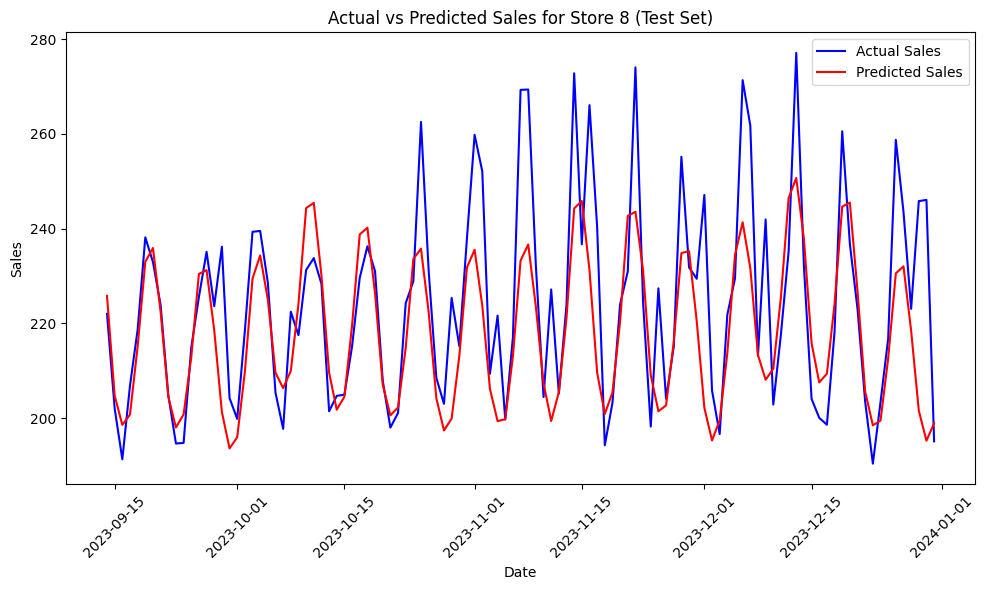

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Evaluating model for Store 9...
Store 9 - Test Set Metrics: MAE: 11.5587 RMSE: 16.8680 MAPE: 4.8363%


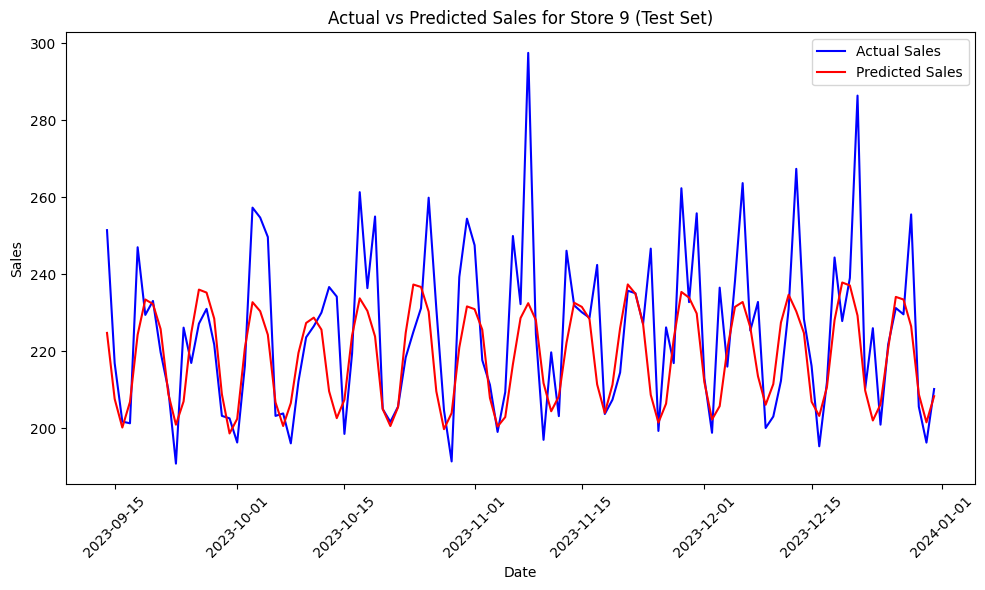

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Evaluating model for Store 10...
Store 10 - Test Set Metrics: MAE: 15.1704 RMSE: 18.4667 MAPE: 6.4370%


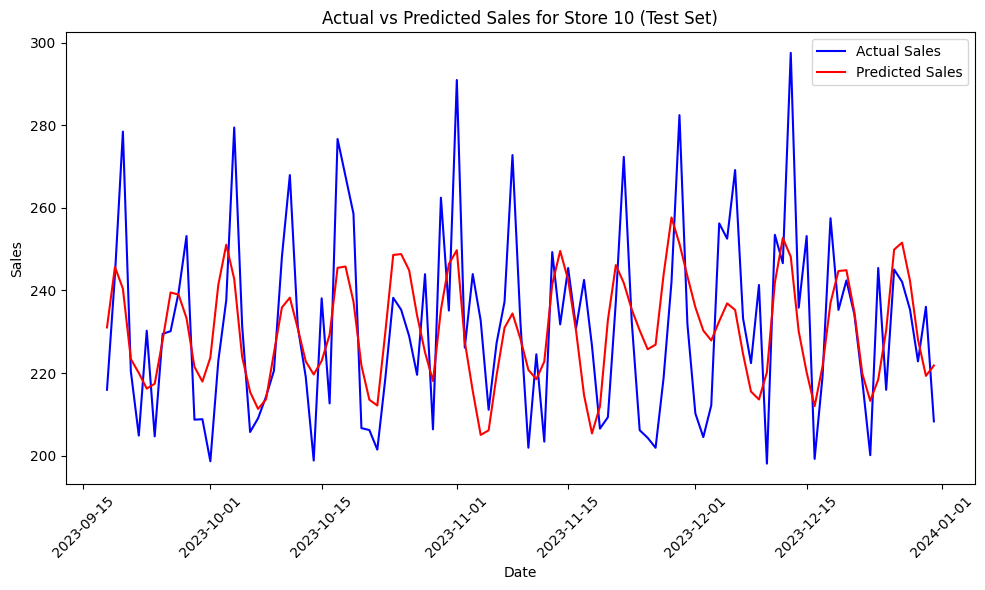

In [36]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load preprocessed data
df = pd.read_csv('store_sales.csv')
df['date'] = pd.to_datetime(df['date'])
stores = df['store'].unique()

# Scale sales data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dfs = []
for store in stores:
    store_df = df[df['store'] == store].copy()
    store_df['sales_scaled'] = scaler.fit_transform(store_df[['sales']])
    scaled_dfs.append(store_df)

df = pd.concat(scaled_dfs, ignore_index=True)
df['day_of_week'] = df['date'].dt.dayofweek
df['month_scaled'] = (df['date'].dt.month - 1) / 11
df['day_of_month_scaled'] = (df['date'].dt.day - 1) / 30
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')

# Load scaler and best models
scaler = joblib.load('scalers.pkl')  # Load the single scaler
best_models = {}
for store in stores:
    best_models[store] = joblib.load(f'best_model_store_{store}.joblib')

# Function to evaluate and plot for each store
def evaluate_and_plot(store, X_test, y_test, store_df):
    # Load the best model for this store
    model = best_models[store]
    
    # Get the best parameters from Step 8 results
    best_params = {
        1: {'seq_length': 7, 'units': 100, 'lr': 0.001},
        2: {'seq_length': 30, 'units': 100, 'lr': 0.001},
        3: {'seq_length': 7, 'units': 50, 'lr': 0.001},
        4: {'seq_length': 7, 'units': 50, 'lr': 0.01},
        5: {'seq_length': 30, 'units': 50, 'lr': 0.01},
        6: {'seq_length': 14, 'units': 100, 'lr': 0.001},
        7: {'seq_length': 30, 'units': 50, 'lr': 0.001},
        8: {'seq_length': 7, 'units': 50, 'lr': 0.001},
        9: {'seq_length': 7, 'units': 100, 'lr': 0.001},
        10: {'seq_length': 30, 'units': 100, 'lr': 0.01}
    }[store]
    seq_length = best_params['seq_length']
    
    # Predict on test set
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values using the single scaler
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
    
    # Print metrics
    print(f"Evaluating model for Store {store}...")
    print(f"Store {store} - Test Set Metrics: MAE: {mae:.4f} RMSE: {rmse:.4f} MAPE: {mape:.4f}%")
    
    # Plot actual vs predicted sales
    plt.figure(figsize=(10, 6))
    test_dates = store_df['date'].iloc[-len(y_test_actual):].values
    plt.plot(test_dates, y_test_actual, label='Actual Sales', color='blue')
    plt.plot(test_dates, y_pred_actual, label='Predicted Sales', color='red')
    plt.title(f'Actual vs Predicted Sales for Store {store} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to recreate test data
def recreate_test_data(store_df, seq_length):
    feature_cols = ['sales_scaled', 'promo', 'holiday', 'month_scaled', 'day_of_month_scaled'] + \
                   [col for col in store_df.columns if col.startswith('dow_')]
    store_df['lagged_sales'] = store_df['sales_scaled'].shift(7).fillna(0)
    store_df['moving_avg_7'] = store_df['sales_scaled'].rolling(window=7).mean().fillna(store_df['sales_scaled'].mean())
    feature_cols.extend(['lagged_sales', 'moving_avg_7'])
    
    X, y = [], []
    for i in range(len(store_df) - seq_length):
        seq = store_df[feature_cols].iloc[i:i + seq_length].values
        target = store_df['sales_scaled'].iloc[i + seq_length]
        X.append(seq)
        y.append(target)
    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    # Split to match original 15% test set
    total_samples = len(X)
    test_start = int(0.85 * total_samples)
    X_test = X[test_start:]
    y_test = y[test_start:]
    
    return X_test, y_test

# Evaluate and plot for each store
for store in stores:
    store_df = df[df['store'] == store].sort_values('date')
    best_seq_length = {
        1: 7, 2: 30, 3: 7, 4: 7, 5: 30, 6: 14, 7: 30, 8: 7, 9: 7, 10: 30
    }[store]
    X_test, y_test = recreate_test_data(store_df, best_seq_length)
    evaluate_and_plot(store, X_test, y_test, store_df)